## Patch TST

## Nano-GPT Entropy Model

## Model Loading

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # must be BEFORE torch/TF import
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.optim as optim
import torch.nn.functional as F
from bytelatent.model.blt import ByteLatentTransformerArgs, ByteLatentTransformer
from chronos import MeanScaleUniformBins, ChronosConfig
from utils.train_utils import *
from TLLM_data_provider.data_factory import data_provider
import argparse
from tqdm import tqdm
import time
torch.cuda.set_device(0)   # 0 here means “the first visible GPU”, i.e. physical #3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from bytelatent.tokenizers.constants import PAD_ID

In [7]:
## Training Args
vocab_size = 4096
batch_size = 64
seq_len = 96
learning_rate = 5e-4
weight_decay = 1e-2
epochs = 10
grad_accumulation_steps = 1
clip_grad = 1.0
seed = 42
warmup_steps = 0
min_lr_factor = 0.1
decay_lr = True
compile = True
output_dir = "output"
save_every = 1
compile = False

In [8]:
# Model Args
dim = 256 # [64, 128, 256, 512]
vocab_size=vocab_size
max_length=seq_len
local_attention_window_len=seq_len
max_seqlen=seq_len
max_encoder_seq_length=seq_len

dim_local_encoder=256 # [64, 128, 256, 512]
dim_local_decoder=256 # [64, 128, 256, 512]
n_layers_global = 2 # [2, 4, 6, 8]
n_layers_local_decoder=2 # [2, 4, 6, 8]
n_layers_local_encoder=2 # [2, 4, 6, 8]
cross_attn_k=2 # [2, 4, 6]
cross_attn_nheads=2 # [2, 4, 6, 8]
patch_size=8

patching_mode="static"
tie_local_encoder_decoder_logits=False
patch_in_forward=False
pad_to_max_length=True
patching_threshold=3.1439168453216553

encoder_hash_byte_group_size=[4,5,6,7,8] 
encoder_hash_byte_group_vocab=2**15 # [2**12, 2**13, 2**14, 2**15, 2**16]
encoder_hash_byte_group_nb_functions=1
encoder_enable_byte_ngrams=False

cross_attn_encoder=True
cross_attn_decoder=True
cross_attn_window_encoder=None
cross_attn_window_decoder=None
cross_attn_all_layers_decoder=True
cross_attn_all_layers_encoder=True
cross_attn_use_flex_attention=False
cross_attn_init_by_pooling=True

log_patch_lengths=True
non_linearity="swiglu"
use_rope=True
recompute_fc1_out=False
recompute_fc3_out=False
recompute_attn=False
custom_bwd=False
layer_ckpt="none"
use_local_encoder_transformer=True
init_use_gaussian=True
init_use_depth="current"
attn_impl="sdpa"
attn_bias_type="causal"
alpha_depth="disabled"

downsampling_by_pooling="max"

In [9]:
# ByteLatentTransformerArgs(dim=512, n_layers=8, head_dim=None, n_heads=8, n_kv_heads=None, ffn_dim_multiplier=1.0, multiple_of=256, norm_eps=1e-05, rope_theta=10000.0, 
#                           rope_use_fp32_in_outer_product=False, init_base_std=None, init_std_factor=<InitStdFactor.DISABLED: 'disabled'>, max_seqlen=1024, attn_impl='sdpa', attn_bias_type='causal', 
#                           eos_id=2, seed=42, vocab_size=-1, weight_tying=False, patch_in_forward=False, dim_token=None, dim_global=512, dim_local_decoder=512, dim_local_encoder=512,
#                             n_layers_global=8, n_layers_local_decoder=8, n_layers_local_encoder=8, patch_size=None, patching_mode=None, patching_threshold=None, patching_threshold_add=None, 
#                             monotonicity=False, patching_batch_size=None, patching_device='cuda', max_patch_length=None, tie_local_encoder_decoder_logits=False, use_local_encoder_transformer=False, 
#                             encoder_lm_loss=False, max_encoder_seq_length=None, pad_to_max_length=False, encoder_enable_byte_ngrams=False, encoder_enable_byte_group_hash=False, ngram_vocab_sizes=None, 
#                             cross_attn_encoder=False, cross_attn_decoder=False, cross_attn_window_encoder=None, cross_attn_window_decoder=None, cross_attn_k=None, cross_attn_nheads=None,
#                               cross_attn_all_layers_decoder=False, cross_attn_all_layers_encoder=False, cross_attn_use_flex_attention=True, cross_attn_init_by_pooling=False, encoder_hash_byte_group_size=None,
#                               encoder_hash_byte_group_vocab=30000, encoder_hash_byte_group_nb_functions=3, log_patch_lengths=False, non_linearity='swiglu', use_rope=True, recompute_fc1_out=False, recompute_fc3_out=False,
#                                 recompute_attn=True, custom_bwd=False, layer_ckpt='all', init_use_gaussian=True, init_use_depth='current', alpha_depth='disabled', max_length=2048, norm_affine=True, pre_norm=True,
#                                   norm_type='rmsnorm', dropout=0, output_size=-1, architecture='vanilla', share_encoder_decoder_emb=True, global_local_decoder_residual_layer=None, tokenize_with_bpe_delimiter=False,
#                                     patching_thresholds_str=None, tie_local_encoder_decoder=False, encoder_preds_low_entropy_toks=None, encoder_preds_random_toks=None, dim_token_emb=None, dim_patch_emb=None,
#                                       encoder_ngram_table_dir=None, encoder_ngram_to_size_str=None, entropy_model_checkpoint_dir=None, entropy_model_is_ngram_model=False, downsampling_by_pooling=None, n_heads_global=8, 
#                                       n_heads_local_decoder=8, n_heads_local_encoder=8, n_kv_heads_global=None, conv_kernel_size=None, local_attention_window_len=None, 
#                           sequence_parallel=False, loss_parallel=False, fuse_sequence_parallel=False, use_fsdp=True, attn_to_keep='all', pm_size=0, full_logging_n_layers=4)

In [10]:
model_args = ByteLatentTransformerArgs(
    seed=seed,
    vocab_size=vocab_size,
    dim=dim, 
    n_layers_global=n_layers_global,  
    n_layers_local_decoder=n_layers_local_decoder, 
    n_layers_local_encoder=n_layers_local_encoder,  
    patch_size=patch_size,
    patching_mode=patching_mode,
    tie_local_encoder_decoder_logits=tie_local_encoder_decoder_logits,
    patch_in_forward=patch_in_forward,
    max_encoder_seq_length=max_encoder_seq_length,
    pad_to_max_length=pad_to_max_length,
    patching_threshold=patching_threshold,
    encoder_hash_byte_group_size=encoder_hash_byte_group_size,
    encoder_hash_byte_group_vocab=encoder_hash_byte_group_vocab,
    encoder_hash_byte_group_nb_functions=encoder_hash_byte_group_nb_functions,
    encoder_enable_byte_ngrams=encoder_enable_byte_ngrams,
    cross_attn_encoder=cross_attn_encoder,
    cross_attn_decoder=cross_attn_decoder,
    cross_attn_window_encoder=cross_attn_window_encoder,
    cross_attn_window_decoder=cross_attn_window_decoder,
    dim_local_encoder=dim_local_encoder,
    dim_local_decoder=dim_local_decoder,
    cross_attn_k=cross_attn_k,   
    cross_attn_nheads=cross_attn_nheads,  
    cross_attn_all_layers_decoder=cross_attn_all_layers_decoder,
    cross_attn_all_layers_encoder=cross_attn_all_layers_encoder,
    cross_attn_use_flex_attention=cross_attn_use_flex_attention,
    cross_attn_init_by_pooling=cross_attn_init_by_pooling,
    log_patch_lengths=log_patch_lengths,
    non_linearity=non_linearity,
    use_rope=use_rope,
    recompute_fc1_out=recompute_fc1_out,
    recompute_fc3_out=recompute_fc3_out,
    recompute_attn=recompute_attn,
    custom_bwd=custom_bwd,
    layer_ckpt=layer_ckpt,
    use_local_encoder_transformer=use_local_encoder_transformer,
    init_use_gaussian=init_use_gaussian,
    init_use_depth=init_use_depth,
    attn_impl=attn_impl,
    attn_bias_type=attn_bias_type,
    alpha_depth=alpha_depth,
    max_length=max_length,
    local_attention_window_len=local_attention_window_len,
    max_seqlen=max_seqlen,
    downsampling_by_pooling=downsampling_by_pooling,
)

In [11]:
model = ByteLatentTransformer(model_args)
model = model.to(device)
if compile:
    model = torch.compile(model)

# n of params in model in millions
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in model: {count_parameters(model) / 1e6:.2f}M")

Number of parameters in model: 55.71M


In [12]:
# 336 > 42, 8
# 96 > 12, 8
# 512 > 64, 8

l = torch.full((batch_size,12), 8).to('cuda')
l[:,0] = 1
l[:,-1] = 10
l[:,2] = 10
l[:,1] = 11
patch_lengths = l
patch_lengths.shape, patch_lengths[0].sum().item()
assert  patch_lengths[0].sum().item() == seq_len

In [13]:
patch_lengths[0].sum().item()

96

In [14]:
optimizer = optim.AdamW(
        model.parameters(), 
        lr=5e-4, 
        weight_decay=0.01,
        betas=(0.9, 0.95)  # Use better beta values from first code
    )
optimizer.zero_grad(set_to_none=True)

In [15]:
torch.manual_seed(model_args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(model_args.seed)
torch.set_float32_matmul_precision('high')
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
scaler = torch.amp.GradScaler(enabled=(dtype == 'float16'))
print(f"Using precision: {dtype}")

Using precision: bfloat16


## Tokenizer

In [16]:
# Create a new config with prediction_length=1
train_tokenizer_config = ChronosConfig(
    tokenizer_class='MeanScaleUniformBins',
    tokenizer_kwargs={'low_limit': -15.0, 'high_limit': 15.0},
    context_length=96,
    prediction_length=96,   
    n_tokens=vocab_size,
    n_special_tokens=4,
    pad_token_id=-1,
    eos_token_id=0,
    use_eos_token=False,
    model_type='causal',
    num_samples=1,
    temperature=1.0,
    top_k=50,
    top_p=1.0
)

# Create a new tokenizer with the updated config
tokenizer = MeanScaleUniformBins(-15, 15, train_tokenizer_config)

## Data Loader

In [17]:
config = {
    'task_name': 'pretrain_long_term_forecast',
    'dataset': 'ETTm2',
    'data' : 'ETTm2',
    'embed' : 'timeF',
    'root_path': 'dataset/ETT-small/',
    'data_path': 'ETTm2.csv',
    'features': 'S',
    'seq_len': seq_len,
    'label_len': seq_len - 1,
    'pred_len': 1
}

args = argparse.Namespace(
    batch_size=batch_size,
    freq='m',
    num_workers=2,
    subsample_pct=None,
    fix_seed=42,
    target='OT',
    shuffle=True,
    scale=True
)

train_dataset, train_loader = data_provider(args, config, flag='train')
validate_dataset, validate_loader = data_provider(args, config, flag='val')
test_dataset, test_loader = data_provider(args, config, flag='test')

In [18]:
# sample a batch
for i, (x, y, x_mark, y_mark) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    print(x_mark.shape)
    print(y_mark.shape)
    break

torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])


In [19]:
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    batch_x_mark = batch_x_mark.to(device)
    batch_y_mark = batch_y_mark.to(device)
    x = batch_x.float().squeeze(-1)
    y = batch_y.float().squeeze(-1)
    break
x.shape, y.shape 


(torch.Size([64, 96]), torch.Size([64, 96]))

## Entropy Model

In [14]:
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

def calculate_entropies_optimized(
    tokens: torch.tensor,
    entropy_model,
    patching_batch_size,
    device: str | None = None,
    enable_grad: bool = False,
):
    """
    Optimized version for T5/encoder-decoder models using vectorized computation.
    tokens: 2D tensor of shape [batch_size, seq_len]
    Return 2D tensor of shape [batch_size, seq_len] with entropies for each token.
    """
    grad_context = torch.no_grad() if not enable_grad else torch.nullcontext()
    
    with grad_context:
        entropies = []
        max_length = getattr(entropy_model, "max_length", 512)
        batch_numel = max_length * patching_batch_size
        splits = torch.split(tokens.flatten(), batch_numel)
        vocab_size = entropy_model.config.n_tokens
        decoder_start_token_id = 0
        
        for split in splits:
            pad_size = (max_length - (split.numel() % max_length)) % max_length
            pad = torch.zeros(
                pad_size, dtype=split.dtype, device=split.device, requires_grad=False
            )
            split = torch.cat((split, pad), dim=0)
            split = split.reshape(-1, max_length)  # shape [B, L]
            
            if device is not None:
                split = split.to(device)
            
            B, L = split.shape
            
            # Vectorized approach: create all contexts at once
            # Instead of processing each position sequentially, we'll batch multiple positions
            chunk_entropies = []
            
            # Process in smaller chunks to manage memory
            position_chunk_size = min(16, L-1)  # Process multiple positions at once
            
            for pos_start in range(1, L, position_chunk_size):
                pos_end = min(pos_start + position_chunk_size, L)
                
                # Create batched contexts for positions pos_start to pos_end
                contexts = []
                attention_masks = []
                decoder_inputs = []
                
                for pos in range(pos_start, pos_end):
                    context = split[:, :pos]  # tokens 0 to pos-1
                    attention_mask = torch.ones_like(context, dtype=torch.bool, device=device)
                    decoder_input_ids = torch.full(
                        (B, 1), decoder_start_token_id, dtype=torch.long, device=device
                    )
                    
                    contexts.append(context)
                    attention_masks.append(attention_mask)
                    decoder_inputs.append(decoder_input_ids)
                
                # Batch the contexts by expanding batch dimension
                # We'll process all positions for all sequences together
                all_logits = []
                
                for i, (context, attention_mask, decoder_input_ids) in enumerate(
                    zip(contexts, attention_masks, decoder_inputs)
                ):
                    with torch.no_grad():
                        outputs = entropy_model.model(
                            input_ids=context.to(device),
                            attention_mask=attention_mask.to(device),
                            decoder_input_ids=decoder_input_ids,
                            output_hidden_states=False,
                            output_attentions=False,
                            return_dict=True,
                        )
                        logits = outputs.logits[:, -1, :]  # shape: [B, vocab]
                        all_logits.append(logits)
                
                # Stack logits for this chunk
                if all_logits:
                    chunk_logits = torch.stack(all_logits, dim=1)  # [B, chunk_size, vocab]
                    chunk_entropy = entropy(chunk_logits)  # [B, chunk_size]
                    chunk_entropies.append(chunk_entropy)
            
            # Concatenate all position chunks
            if chunk_entropies:
                split_entropies = torch.cat(chunk_entropies, dim=1)  # [B, L-1]
                
                # Add zero entropy for first position
                first_pos_entropy = torch.zeros(B, 1, device=device)
                split_entropies = torch.cat([first_pos_entropy, split_entropies], dim=1)
            else:
                split_entropies = torch.zeros(B, L, device=device)
            
            # Flatten and remove padding
            split_entropies = split_entropies.flatten()[:split.numel() - pad_size]
            entropies.append(split_entropies)
        
        # Concatenate all splits and reshape to original shape
        concat_entropies = torch.cat(entropies, dim=0)
        concat_entropies = concat_entropies.reshape(tokens.shape)
        
    return concat_entropies

def calculate_entropies_fully_vectorized(
    tokens: torch.tensor,
    entropy_model,
    patching_batch_size,
    device: str | None = None,
    enable_grad: bool = False,
):
    """
    Fully vectorized version that processes multiple positions simultaneously.
    Most aggressive optimization for T5/encoder-decoder models.
    """
    grad_context = torch.no_grad() if not enable_grad else torch.nullcontext()
    
    with grad_context:
        entropies = []
        max_length = getattr(entropy_model, "max_length", 512)
        batch_numel = max_length * patching_batch_size
        splits = torch.split(tokens.flatten(), batch_numel)
        vocab_size = entropy_model.config.n_tokens
        decoder_start_token_id = 0
        
        for split in splits:
            pad_size = (max_length - (split.numel() % max_length)) % max_length
            pad = torch.zeros(
                pad_size, dtype=split.dtype, device=split.device, requires_grad=False
            )
            split = torch.cat((split, pad), dim=0)
            split = split.reshape(-1, max_length)  # shape [B, L]
            
            if device is not None:
                split = split.to(device)
            
            B, L = split.shape
            
            # Create all contexts at once by stacking them
            max_context_len = L - 1
            
            # Pre-allocate tensors for all contexts
            all_contexts = []
            all_attention_masks = []
            position_mapping = []
            
            for seq_idx in range(B):
                for pos in range(1, L):
                    context = split[seq_idx:seq_idx+1, :pos]  # [1, pos]
                    attention_mask = torch.ones_like(context, dtype=torch.bool, device=device)
                    
                    all_contexts.append(context)
                    all_attention_masks.append(attention_mask)
                    position_mapping.append((seq_idx, pos))
            
            if not all_contexts:
                split_entropies = torch.zeros(B, L, device=device)
            else:
                # Pad all contexts to the same length for efficient batching
                padded_contexts = torch.nn.utils.rnn.pad_sequence(
                    [ctx.squeeze(0) for ctx in all_contexts], 
                    batch_first=True, 
                    padding_value=0
                )
                
                padded_attention_masks = torch.nn.utils.rnn.pad_sequence(
                    [mask.squeeze(0) for mask in all_attention_masks],
                    batch_first=True,
                    padding_value=False
                )
                
                # Create decoder input ids for all contexts
                decoder_input_ids = torch.full(
                    (len(all_contexts), 1), 
                    decoder_start_token_id, 
                    dtype=torch.long, 
                    device=device
                )
                
                # Process all contexts in one forward pass
                with torch.no_grad():
                    outputs = entropy_model.model(
                        input_ids=padded_contexts,
                        attention_mask=padded_attention_masks,
                        decoder_input_ids=decoder_input_ids,
                        output_hidden_states=False,
                        output_attentions=False,
                        return_dict=True,
                    )
                    
                    logits = outputs.logits[:, -1, :]  # [num_contexts, vocab]
                    context_entropies = entropy(logits)  # [num_contexts]
                
                # Map back to original positions
                split_entropies = torch.zeros(B, L, device=device)
                for i, (seq_idx, pos) in enumerate(position_mapping):
                    split_entropies[seq_idx, pos] = context_entropies[i]
            
            # Flatten and remove padding
            split_entropies = split_entropies.flatten()[:split.numel() - pad_size]
            entropies.append(split_entropies)
        
        # Concatenate all splits and reshape to original shape
        concat_entropies = torch.cat(entropies, dim=0)
        concat_entropies = concat_entropies.reshape(tokens.shape)
        
    return concat_entropies

def calculate_entropies_kv_cache(
    tokens: torch.tensor,
    entropy_model,
    patching_batch_size,
    device: str | None = None,
    enable_grad: bool = False,
):
    """
    Version using KV caching for incremental computation.
    Most efficient for very long sequences.
    """
    if not hasattr(entropy_model.model, 'generate'):
        # Fallback to batch method if KV cache not supported
        return calculate_entropies_optimized(tokens, entropy_model, patching_batch_size, device, enable_grad)
    
    grad_context = torch.no_grad() if not enable_grad else torch.nullcontext()
    
    with grad_context:
        batch_size, seq_len = tokens.shape
        vocab_size = entropy_model.config.n_tokens
        
        if device is not None:
            tokens = tokens.to(device)
        
        entropies = torch.zeros_like(tokens, dtype=torch.float, device=device)
        
        # Process each sequence in the batch
        for batch_idx in range(batch_size):
            sequence = tokens[batch_idx:batch_idx+1]  # Keep batch dimension
            past_key_values = None
            
            for pos in range(1, seq_len):
                # Use only the current token for input (with KV cache)
                if pos == 1:
                    input_ids = sequence[:, :pos]
                else:
                    input_ids = sequence[:, pos-1:pos]
                
                with torch.no_grad():
                    outputs = entropy_model.model(
                        input_ids=input_ids,
                        past_key_values=past_key_values,
                        use_cache=True,
                        return_dict=True,
                    )
                    
                    logits = outputs.logits[:, -1, :]  # Last position logits
                    past_key_values = outputs.past_key_values
                    
                    # Calculate entropy for current position
                    token_entropy = entropy(logits.unsqueeze(1)).squeeze(1)
                    entropies[batch_idx, pos] = token_entropy
        
    return entropies

def calculate_entropies_parallel_chunks(
    tokens: torch.tensor,
    entropy_model,
    patching_batch_size,
    device: str | None = None,
    enable_grad: bool = False,
    num_chunks: int = 4,
):
    """
    Process multiple chunks in parallel using different GPU streams.
    Requires multiple GPUs or careful memory management.
    """
    if not torch.cuda.is_available() or torch.cuda.device_count() < 2:
        # Fallback to optimized version
        return calculate_entropies_optimized(tokens, entropy_model, patching_batch_size, device, enable_grad)
    
    grad_context = torch.no_grad() if not enable_grad else torch.nullcontext()
    
    with grad_context:
        batch_size, seq_len = tokens.shape
        chunk_size = seq_len // num_chunks
        
        streams = [torch.cuda.Stream() for _ in range(num_chunks)]
        chunk_results = []
        
        for i in range(num_chunks):
            start_idx = i * chunk_size
            end_idx = start_idx + chunk_size if i < num_chunks - 1 else seq_len
            
            with torch.cuda.stream(streams[i]):
                chunk_tokens = tokens[:, start_idx:end_idx].to(f'cuda:{i % torch.cuda.device_count()}')
                
                # Process chunk (similar to optimized version)
                outputs = entropy_model.model(
                    input_ids=chunk_tokens,
                    attention_mask=torch.ones_like(chunk_tokens, dtype=torch.bool),
                    return_dict=True,
                )
                
                logits = outputs.logits[:, :-1, :]
                chunk_entropies = entropy(logits)
                
                # Add padding for first position
                first_pos = torch.zeros(batch_size, 1, device=chunk_tokens.device)
                chunk_entropies = torch.cat([first_pos, chunk_entropies], dim=1)
                
                chunk_results.append(chunk_entropies)
        
        # Synchronize all streams
        for stream in streams:
            stream.synchronize()
        
        # Concatenate results
        final_entropies = torch.cat([r.to(device) for r in chunk_results], dim=1)
        
    return final_entropies

# Additional utility function for entropy calculation
def entropy(scores):
    """
    Vectorized entropy calculation with numerical stability.
    scores: [..., vocab_size]
    returns [...] (same shape as input except last dimension)
    """
    log_probs = F.log_softmax(scores, dim=-1)
    probs = torch.exp(log_probs)
    
    # Numerical stability: handle log(0) cases
    entropy = -(probs * log_probs).sum(dim=-1)
    return entropy

In [25]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
import json
import logging
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
from typing import Optional, List, Tuple, Dict, Union
from transformers import AutoConfig, AutoModelForSeq2SeqLM
from chronos import ChronosModel, ChronosConfig
import numpy as np
import torch
from contextlib import nullcontext
from bytelatent.transformer import LMTransformer, LMTransformerArgs

logger = logging.getLogger()


def load_entropy_model(entropy_model_checkpoint_dir="amazon/chronos-t5-tiny", state_dict_path="no_need", device="cuda"):

    model_path = entropy_model_checkpoint_dir
    torch.set_default_dtype(torch.bfloat16)

    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    else:
        device = device

    # Load Chronos model
    config = AutoConfig.from_pretrained(model_path)
    chronos_config = ChronosConfig(**config.chronos_config)
    pretrained_model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
    entropy_model = ChronosModel(config=chronos_config, model=pretrained_model)
    entropy_model.to(device)
    entropy_model = entropy_model.eval()

    return entropy_model

def entropy(scores):
    """
    scores: [bs, seq_len, vocab]
    returns [bs, seq_len]

    Computes the entropy for each token in the batch.
    Note: uses natural log.
    """
    log_probs = F.log_softmax(scores, dim=-1)
    probs = torch.exp(log_probs)
    p_log_p = log_probs * probs
    entropy = -p_log_p.sum(dim=-1)
    return entropy

def calculate_entropies(
    tokens: torch.tensor,
    entropy_model,
    patching_batch_size,
    device: str | None = None,
    enable_grad: bool = False,
):
    """
    tokens: 2D tensor of shape [batch_size, seq_len]
    Return 2D tensor of shape [batch_size, seq_len] with entropies for each token.

    Splits the tokens into chunks of size max_length and calculates entropies for each chunk.
    Entropy model can be executed on cpu or gpu, specify either 'cuda' or 'cpu' in the device argument.
    """

    grad_context = nullcontext() if enable_grad else torch.no_grad()

    with grad_context:
        entropies = []
        preds = []
        max_length = getattr(entropy_model, "max_length", 256)
        batch_numel = max_length * patching_batch_size
        splits = torch.split(tokens.flatten(), batch_numel)
        vocab_size = entropy_model.config.n_tokens
        decoder_start_token_id = 0
        # Save original shape
        # original_shape = tokens.shape
        # vocab_size = entropy_model.config.n_tokens

        # Flatten the tokens for uniform processing
        # flat_tokens = tokens.flatten()
        # splits = torch.split(tokens.flatten(), batch_numel)

        for split in splits:
            pad_size = (max_length - (split.numel() % max_length)) % max_length
            pad = torch.zeros(
                    pad_size, dtype=split.dtype, device=split.device, requires_grad=False
                )
            split = torch.cat((split, pad), dim=0)
            split = split.reshape(-1, max_length) # shape [B, L]
            if device is not None:
                split = split.to(device)
            # if pad_size > 0:
            #     split = torch.cat([split, torch.zeros(pad_size, dtype=split.dtype, device=split.device, requires_grad=False)])

            
            B, L = split.shape

            # Allocate per-split outputs
            # entropy_per_split = torch.zeros((B, L), device=device)
            pred = torch.zeros((B, L, vocab_size), device=device)

            for i in range(1, L):
                context = split[:, :i]  # tokens 0 to i-1
                attention_mask = torch.ones_like(context, dtype=torch.bool, device=device)

                decoder_input_ids = torch.full(
                    (B, 1),
                    decoder_start_token_id,
                    dtype=torch.long,
                    device=device,
                )

                with torch.no_grad():
                    outputs = entropy_model.model(
                        input_ids=context.to(device),
                        attention_mask=attention_mask.to(device),
                        decoder_input_ids=decoder_input_ids,
                        output_hidden_states=False,
                        output_attentions=False,
                        return_dict=True,
                    )
                    logits = outputs.logits[:, -1, :]  # shape: [B, vocab]
                    pred[:, i, :] = logits

            pred = pred.reshape(-1, pred.shape[-1])[
                        : split.numel() - pad_size, :
                    ]  # [batch_size * seq_len, vocab]

            pred_entropies = entropy(pred)
            entropies.append(pred_entropies)
            preds.append(pred)
        concat_entropies = torch.cat(entropies, dim=0)
        concat_entropies = concat_entropies.reshape(tokens.shape)
        concat_preds = torch.cat(preds, dim=0)
        concat_preds = concat_preds.reshape(tokens.shape[0], -1)
    return concat_entropies, concat_preds


In [26]:
tokens = torch.randint(3, 100, (128, 96), device='cuda')
entropy_model = load_entropy_model()
patching_batch_size = 32
device = 'cuda'
enable_grad = False

vocab_size = entropy_model.config.n_tokens
entropy_model = load_entropy_model()

In [28]:

e  = calculate_entropies(
    tokens=tokens,
    entropy_model=entropy_model,
    patching_batch_size=patching_batch_size,
    device=device,
    enable_grad=False
)
e

(tensor([[8.3750, 7.0000, 6.8125,  ..., 6.7812, 6.7812, 6.7812],
         [6.8125, 6.8438, 6.8125,  ..., 6.8125, 6.8125, 6.8438],
         [6.7500, 6.7812, 6.8125,  ..., 6.6875, 6.7188, 6.6875],
         ...,
         [6.7500, 6.8438, 6.8438,  ..., 6.8125, 6.7500, 6.8125],
         [6.7812, 6.8125, 6.7188,  ..., 6.8125, 6.7812, 6.8438],
         [6.8750, 6.8125, 6.8125,  ..., 6.7812, 6.8125, 6.8438]],
        device='cuda:0'),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 2.2812, 2.7969, 0.5039],
         [2.8906, 0.5234, 3.3594,  ..., 2.1250, 2.6250, 0.4297],
         [2.8750, 0.5742, 3.2812,  ..., 1.7656, 2.2656, 0.2793],
         ...,
         [2.8281, 0.6172, 3.1094,  ..., 2.0781, 2.5938, 0.4512],
         [2.8594, 0.6641, 3.0938,  ..., 2.1875, 2.6875, 0.4941],
         [2.8594, 0.6328, 3.2969,  ..., 2.1094, 2.6094, 0.4492]],
        device='cuda:0'))

In [22]:
e

tensor([[0.0000, 6.8125, 6.2812,  ..., 6.7812, 6.7812, 6.8125],
        [6.7500, 6.7188, 6.7500,  ..., 6.7188, 6.7812, 6.7812],
        [6.7812, 6.7500, 6.7812,  ..., 6.7812, 6.7812, 6.7188],
        ...,
        [6.8125, 6.8438, 6.7812,  ..., 6.7812, 6.7812, 6.8125],
        [6.7500, 6.7500, 6.8125,  ..., 6.8125, 6.7500, 6.8125],
        [6.8125, 6.7812, 6.7500,  ..., 6.7812, 6.7812, 6.8125]],
       device='cuda:0')

In [ ]:
# import pandas as pd
# df = pd.read_csv(
#     "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"
# )
# context=torch.tensor(df["#Passengers"])
# tokens,_,_ = tokenizer.context_input_transform(context.unsqueeze(0).cpu())
# tokens.shape

torch.Size([1, 144])

In [ ]:


max_length = getattr(entropy_model, "max_length", 512)
batch_numel = max_length * patching_batch_size
device = 'cuda'

epsilon = 1e-10

decoder_start_token_id = 0

In [7]:
# tokens, entropy_model, patching_batch_size, device, enable_grad
from contextlib import nullcontext

torch.Size([64, 336])

In [14]:
entropy = entropy(pred)
entropy.shape

TypeError: 'Tensor' object is not callable

In [ ]:
total_valid_tokens = split.numel() - pad_len
pred = pred.view(-1)[:total_valid_tokens] 
pred_per_split = pred_per_split.view(-1, vocab_size)[:total_valid_tokens]

tensor([0.0000, 0.0000, 0.0000,  ..., 2.7031, 3.1875, 0.5352], device='cuda:0')

In [186]:
cal_entropy(pred) 

tensor([[8.3750, 6.8125, 6.6562,  ..., 6.8125, 6.7500, 6.7188],
        [8.3750, 6.4062, 6.8438,  ..., 6.7812, 6.7500, 6.7500],
        [8.3750, 6.6562, 7.0000,  ..., 6.7812, 6.7812, 6.7812],
        ...,
        [8.3750, 6.9375, 6.9062,  ..., 6.7500, 6.8125, 6.7812],
        [8.3750, 6.9688, 6.8750,  ..., 6.8125, 6.7812, 6.7500],
        [8.3750, 6.9375, 6.9688,  ..., 6.7500, 6.7812, 6.8125]],
       device='cuda:0')

In [192]:
pred

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.7500e+00,  5.2344e-01,  3.0781e+00,  ...,  1.8438e+00,
           2.3750e+00,  4.6631e-02],
         [ 2.6406e+00,  2.9297e-01,  2.9688e+00,  ...,  1.7891e+00,
           2.2812e+00,  2.6172e-01],
         ...,
         [ 2.8438e+00,  6.3281e-01,  3.2656e+00,  ...,  2.0781e+00,
           2.5781e+00,  3.5547e-01],
         [ 2.8281e+00,  6.5625e-01,  3.2344e+00,  ...,  2.0469e+00,
           2.5469e+00,  3.6523e-01],
         [ 2.8438e+00,  6.2109e-01,  3.2031e+00,  ...,  2.0312e+00,
           2.5312e+00,  3.5547e-01]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.4531e+00,  5.1172e-01,  1.3047e+00,  ...,  7.3828e-01,
           1.2422e+00, -2.6001e-02],
         [ 2.8906e+00,  4.2969e-01,  3.6406e+00,  ...,  2.5312e+00,
           3.0000e+00,  6.6016e-01],
         ...,
         [ 2.8594e+00,  6

In [181]:
concat_entropies.shape

torch.Size([64, 720])

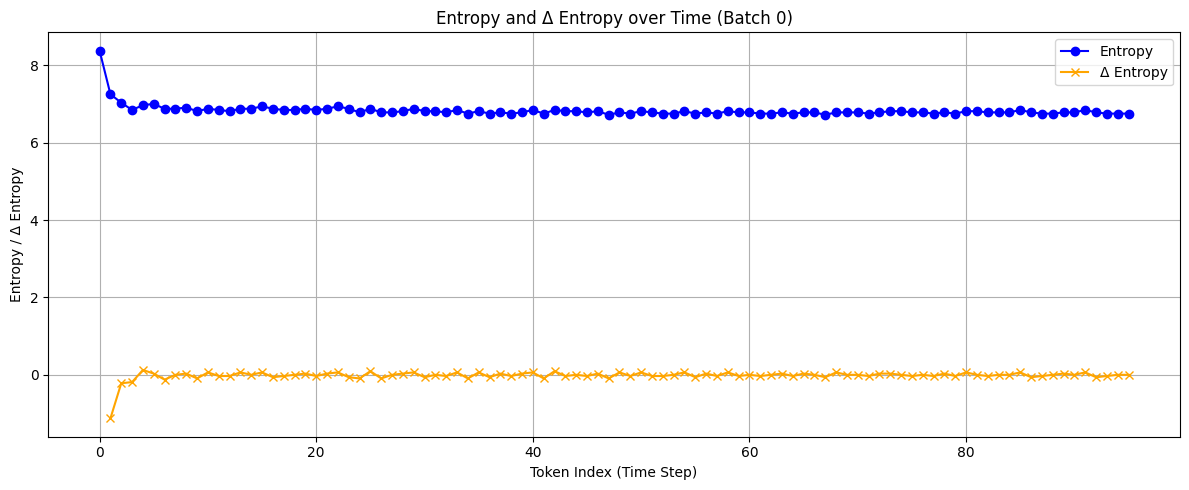

In [37]:
import matplotlib.pyplot as plt

def plot_entropy_and_difference(entropies, batch_index=0):
    """
    Plot entropy and its first difference for a single batch sample.

    Parameters:
    - entropies: torch.Tensor of shape [B, L]
    - batch_index: which sequence in the batch to plot
    """
    entropy_values = entropies[batch_index].detach().cpu().float().numpy()
    diff_values = entropy_values[1:] - entropy_values[:-1]

    plt.figure(figsize=(12, 5))
    
    # Plot entropy
    plt.plot(entropy_values, marker='o', label="Entropy", color='blue')

    # Plot entropy difference (offset by +1)
    plt.plot(range(1, len(entropy_values)), diff_values, marker='x', label="Δ Entropy", color='orange')

    plt.title(f"Entropy and Δ Entropy over Time (Batch {batch_index})")
    plt.xlabel("Token Index (Time Step)")
    plt.ylabel("Entropy / Δ Entropy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function
plot_entropy_and_difference(e, batch_index=0)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
from typing import Optional, List, Tuple, Dict, Union
from transformers import AutoConfig, AutoModelForSeq2SeqLM
from chronos import ChronosModel, ChronosConfig
import numpy as np

warnings.filterwarnings("ignore")

class EntropyModel:
    """
    A wrapper for Chronos model that calculates entropy for time series tokens
    """
    def __init__(
        self, 
        model_path: str = "amazon/chronos-t5-tiny",
        device: Optional[str] = None
    ):
        """
        Initialize the entropy model with a Chronos model.
        
        Args:
            model_path: Path to the Chronos model
            device: Device to run the model on ('cuda', 'cpu', etc.)
        """
        # Set device
        if device is None:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device
            
        # Load Chronos model
        config = AutoConfig.from_pretrained(model_path)
        chronos_config = ChronosConfig(**config.chronos_config)
        pretrained_model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
        self.model = ChronosModel(config=chronos_config, model=pretrained_model)
        self.model.to(self.device)
        self.model.eval()
        
        # Store the chronos config for tokenization
        self.chronos_config = chronos_config
        
    def calculate_entropies(
        self, 
        time_series: torch.Tensor,
        batch_size: int = 1
    ) -> torch.Tensor:
        """
        Calculate the entropy for each position in the time series.
        
        Args:
            time_series: Time series tensor of shape [batch_size, seq_len]
            batch_size: Batch size for processing
            
        Returns:
            Tensor of entropy values of shape [batch_size, seq_len]
        """
        if time_series.dim() == 1:
            time_series = time_series.unsqueeze(0)  # Add batch dimension if not present
            
        batch_size, seq_len = time_series.shape
        all_entropies = torch.zeros((batch_size, seq_len), device=self.device)
        
        # For each position in the sequence
        for i in range(1, seq_len):  # Start from 1 as we need at least one context token
            # Process context up to position i (excluding position i)
            contexts = time_series[:, :i]
            
            # Tokenize inputs
            tokenizer = self.chronos_config.create_tokenizer()
            token_ids, attention_mask, scale = tokenizer.context_input_transform(contexts.to('cpu'))
            
            # For seq2seq models, decoder_input_ids starts with decoder_start_token_id
            decoder_start_token_id = self.model.model.config.decoder_start_token_id
            decoder_input_ids = torch.full(
                (token_ids.shape[0], 1),
                decoder_start_token_id,
                dtype=torch.long,
                device=token_ids.device,
            )
            
            # Get model prediction for the next token (position i)
            with torch.no_grad():
                outputs = self.model.model(
                    input_ids=token_ids.to(self.device),
                    attention_mask=attention_mask.to(self.device),
                    decoder_input_ids=decoder_input_ids.to(self.device),
                    output_hidden_states=False,
                    output_attentions=False,
                    return_dict=True,
                )
                
                # Get logits for the next position
                next_position_logits = outputs.logits[:, -1, :]  # [batch_size, vocab_size]
                
                # Convert logits to probabilities
                next_token_probs = F.softmax(next_position_logits, dim=-1)
                
                # Calculate entropy: -sum(p * log(p))
                epsilon = 1e-10
                entropy = -torch.sum(next_token_probs * torch.log2(next_token_probs + epsilon), dim=-1)
                
                # Store the entropy value for position i
                all_entropies[:, i] = entropy
                
        return all_entropies

    def tokenize_time_series(self, time_series: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Tokenize the time series using the Chronos tokenizer.
        
        Args:
            time_series: Time series tensor
            
        Returns:
            Dictionary with token_ids, attention_mask, and scale
        """
        tokenizer = self.chronos_config.create_tokenizer()
        token_ids, attention_mask, scale = tokenizer.context_input_transform(time_series.to('cpu'))
        
        return {
            "token_ids": token_ids,
            "attention_mask": attention_mask,
            "scale": scale
        }


class EntropyPatcher:
    """
    Patches time series data based on entropy values
    """
    def __init__(
        self, 
        threshold: float = 3.0, 
        min_len: int = 3, 
        max_len: int = 8, 
        mode: str = 'global'
    ):
        """
        Initialize the patcher.
        
        Args:
            threshold: Threshold for entropy-based patching
            min_len: Minimum length of a patch
            max_len: Maximum length of a patch
            mode: Patching mode ('global' or 'relative')
        """
        self.threshold = threshold
        self.min_len = min_len
        self.max_len = max_len
        self.mode = mode
        
        if mode not in ['global', 'relative']:
            raise ValueError(f"Mode must be 'global' or 'relative', got {mode}")
    
    def patch(
        self, 
        token_ids: torch.Tensor, 
        entropies: torch.Tensor
    ) -> Dict[str, torch.Tensor]:
        """
        Create patches based on entropy values.
        
        Args:
            token_ids: Tensor of token IDs [batch_size, seq_len]
            entropies: Tensor of entropy values [batch_size, seq_len]
            
        Returns:
            Dictionary containing:
                - token_ids: Original token IDs [batch_size, seq_len]
                - patch_ids: Patch IDs for each token [batch_size, seq_len]
                - patch_lengths: Length of each patch [batch_size, num_patches]
        """
        if token_ids.dim() == 1:
            token_ids = token_ids.unsqueeze(0)  # Add batch dimension if not present
            
        if entropies.dim() == 1:
            entropies = entropies.unsqueeze(0)  # Add batch dimension if not present
            
        batch_size, seq_len = token_ids.shape
        device = token_ids.device
        
        # Initialize outputs
        patch_ids = torch.zeros_like(token_ids, dtype=torch.long)
        patch_lengths_list = []
        
        for b in range(batch_size):
            # Get patches for this sequence
            patches = self._get_patches(entropies[b])
            
            # Fill in patch_ids and collect patch lengths
            patch_lengths_b = []
            for patch_idx, (start, length) in enumerate(patches):
                patch_ids[b, start:start+length] = patch_idx
                patch_lengths_b.append(length)
            
            patch_lengths_list.append(patch_lengths_b)
        
        # Create patch_lengths tensor with padding
        max_num_patches = max(len(p) for p in patch_lengths_list)
        patch_lengths = torch.zeros((batch_size, max_num_patches), dtype=torch.long, device=device)
        
        for b, lengths in enumerate(patch_lengths_list):
            patch_lengths[b, :len(lengths)] = torch.tensor(lengths, dtype=torch.long, device=device)
        
        return {
            "token_ids": token_ids,
            "patch_ids": patch_ids,
            "patch_lengths": patch_lengths
        }
        
    def _get_patches(self, entropies: torch.Tensor) -> List[Tuple[int, int]]:
        """
        Create patches for a single sequence based on entropy values.
        First patch always has length 1, subsequent patches follow regular logic.
        
        Args:
            entropies: Entropy values for a single sequence
            
        Returns:
            List of (start_position, length) tuples
        """
        patches = []
        L = len(entropies)
        
        # Always make the first patch exactly length 1
        if L > 0:
            patches.append((0, 1))
            start = 1  # Start the next patch from position 1
        else:
            return patches  # Empty sequence
        
        # Process the rest of the sequence with regular logic
        while start < L:
            end = start + self.min_len
            
            # Find the end of this patch
            while end < min(L, start + self.max_len):
                # Check whether to break the patch - only if not at the end of sequence
                should_break = False
                
                if end < L:  # Only check for break if not at the end
                    if self.mode == 'global' and entropies[end] > self.threshold:
                        should_break = True
                    elif self.mode == 'relative' and end > 0 and (entropies[end] - entropies[end-1]) > self.threshold:
                        should_break = True
                
                if should_break:
                    break
                
                end += 1
            
            # Add the patch
            patches.append((start, end - start))
            
            # Move to the next position
            start = end
            
        return patches


class TimeSeriesPatcher:
    """
    Combines EntropyModel and EntropyPatcher to process time series data.
    """
    def __init__(
        self,
        model_path: str = "amazon/chronos-t5-tiny",
        threshold: float = 3.0,
        min_len: int = 3,
        max_len: int = 8,
        mode: str = 'global',
        device: Optional[str] = None
    ):
        """
        Initialize the TimeSeriesPatcher.
        
        Args:
            model_path: Path to the Chronos model
            threshold: Threshold for entropy-based patching
            min_len: Minimum length of a patch
            max_len: Maximum length of a patch
            mode: Patching mode ('global' or 'relative')
            device: Device to run the model on ('cuda', 'cpu', etc.)
        """
        self.entropy_model = EntropyModel(model_path, device)
        self.patcher = EntropyPatcher(threshold, min_len, max_len, mode)
    
    def process(
        self, 
        time_series: Union[torch.Tensor, List[float]],
        return_entropies: bool = False
    ) -> Dict[str, torch.Tensor]:
        """
        Process time series data: tokenize, calculate entropies, and create patches.
        
        Args:
            time_series: Time series data (tensor or list)
            return_entropies: Whether to include entropy values in the output
            
        Returns:
            Dictionary containing:
                - token_ids: Tokenized time series
                - patch_ids: Patch IDs for each token
                - patch_lengths: Length of each patch
                - entropies: (optional) Entropy values
        """
        # Convert to tensor if necessary
        if not isinstance(time_series, torch.Tensor):
            time_series = torch.tensor(time_series, dtype=torch.float)
            
        if time_series.dim() == 1:
            time_series = time_series.unsqueeze(0)  # Add batch dimension
            
        # Move to the correct device
        time_series = time_series.to(self.entropy_model.device)
        
        # Calculate entropies
        entropies = self.entropy_model.calculate_entropies(time_series)
        
        # Tokenize the time series
        tokenization = self.entropy_model.tokenize_time_series(time_series.to('cpu'))
        token_ids = tokenization["token_ids"]
        
        # Create patches
        patching_result = self.patcher.patch(token_ids, entropies)
        
        # Add entropies to the output if requested
        if return_entropies:
            patching_result["entropies"] = entropies
            
        return patching_result

In [ ]:
# import json
# import os
# import logging
# import torch
# from torch import nn

# from bytelatent.transformer import LMTransformer, LMTransformerArgs

# logger = logging.getLogger(__name__)

# def build_entropy_model():
#     """
#     Build an entropy model for time series patching.
#     """
#     # Define model parameters
#     args = LMTransformerArgs(
#         dim=128,                  # Embedding dimension
#         n_layers=4,               # Number of transformer layers
#         n_heads=4,                # Number of attention heads
#         max_seqlen=512,          # Maximum sequence length
#         ffn_dim_multiplier=4,     # Multiplier for FFN dimension
#         vocab_size=4096,           # For byte-level tokens (256 + small offset)
#         attn_bias_type="local_block_causal",  # Use causal attention with local blocks
#         attn_impl="xformers",     # Using xformers attention implementation
#         sliding_window=512,       # Sliding window size for attention
#         weight_tying=False,       # Whether to tie input and output embeddings
#         norm_eps=1e-5,            # Epsilon for normalization
#         seed=42                   # Random seed
#     )
    
#     # Create the model
#     model = LMTransformer(args)
    
#     # Initialize weights
#     model.init_weights()
    
#     return model, args

In [ ]:
# def train_entropy_model(
#     model,
#     train_dataloader,
#     val_dataloader=None,
#     epochs=10,
#     lr=5e-5,
#     device="cuda" if torch.cuda.is_available() else "cpu",
#     checkpoint_dir="./entropy_model_checkpoints",
#     save_every=1,
# ):
#     """
#     Train the entropy model on tokenized time series data.
    
#     Args:
#         model: LMTransformer model
#         train_dataloader: DataLoader for training data
#         val_dataloader: Optional DataLoader for validation
#         epochs: Number of training epochs
#         lr: Learning rate
#         device: Device to train on
#         checkpoint_dir: Directory to save checkpoints
#         save_every: Save checkpoint every N epochs
#     """
#     os.makedirs(checkpoint_dir, exist_ok=True)
#     os.makedirs(os.path.join(checkpoint_dir, "consolidated"), exist_ok=True)
    
#     # Move model to device
#     model = model.to(device)
    
#     # Setup optimizer and scheduler
#     optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#         optimizer, T_max=epochs * len(train_dataloader)
#     )
    
#     # Training loop
#     model.train()
#     for epoch in range(epochs):
#         epoch_loss = 0
#         # for step, batch in enumerate(train_dataloader):
#         for step, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_dataloader):
#             x = batch_x.float().squeeze(-1)
#             y = batch_y.float().squeeze(-1)
            
#             # Tokenize input sequence
#             token_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x)
            
#             # Tokenize target sequence
#             target_token_ids, target_attention_mask = tokenizer.label_input_transform(y, tokenizer_state)
            
#             # Forward pass
#             logits = model(token_ids.to(device), patch_lengths)
        
#             loss = F.cross_entropy(
#                             logits.reshape(-1, logits.size(-1)),
#                             target_token_ids.reshape(-1).to(device),
#                             ignore_index=PAD_ID
#                         )
            
#             # Backward pass
#             optimizer.zero_grad()
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#             optimizer.step()
#             scheduler.step()
            
#             epoch_loss += loss.item()
            
#             # Log progress
#             if step % 100 == 0:
#                 logger.info(f"Epoch {epoch+1}/{epochs}, Step {step}, Loss: {loss.item():.4f}")
        
#         avg_loss = epoch_loss / len(train_dataloader)
#         logger.info(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")
        
#         # Validation
#         if val_dataloader is not None:
#             val_loss = evaluate(model, val_dataloader, device)
#             logger.info(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")
        
#         # Save checkpoint
#         if (epoch + 1) % save_every == 0:
#             save_checkpoint(model, optimizer, checkpoint_dir, epoch)
    
#     # Save final model
#     save_checkpoint(model, optimizer, checkpoint_dir, epochs)
    
#     # Save consolidated weights for inference
#     consolidated_path = os.path.join(checkpoint_dir, "consolidated/consolidated.pth")
#     torch.save({"model": model.state_dict()}, consolidated_path)
    
#     logger.info(f"Model saved to {checkpoint_dir}")
#     return model

# def evaluate(model, dataloader, device):
#     """Evaluate model on the provided dataloader"""
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for batch in dataloader:
#             tokens = batch["input_ids"].to(device)
#             inputs = tokens[:, :-1]
#             targets = tokens[:, 1:]
#             loss = model(inputs, target=targets)
#             total_loss += loss.item()
    
#     model.train()
#     return total_loss / len(dataloader)

# def save_checkpoint(model, optimizer, checkpoint_dir, epoch):
#     """Save model checkpoint"""
#     checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pt")
    
#     # Save model state
#     torch.save(
#         {
#             "model": model.state_dict(),
#             "optimizer": optimizer.state_dict(),
#             "epoch": epoch,
#         },
#         checkpoint_path
#     )
    
#     # Save model parameters for loading
#     args_dict = model.config.__dict__ if hasattr(model, "config") else vars(model.args)
    
#     params = {
#         "entropy_model": {
#             "dim": args_dict["dim"],
#             "n_layers": args_dict["n_layers"],
#             "n_heads": args_dict["n_heads"],
#             "max_seqlen": args_dict["max_seqlen"],
#             "ffn_dim_multiplier": args_dict.get("ffn_dim_multiplier", 4),
#             "vocab_size": args_dict["vocab_size"],
#             "attn_bias_type": args_dict["attn_bias_type"],
#             "attn_impl": args_dict["attn_impl"],
#             "sliding_window": args_dict.get("sliding_window", 512),
#         }
#     }
    
#     with open(os.path.join(checkpoint_dir, "params.json"), "w") as f:
#         json.dump(params, f, indent=4)

In [ ]:
# def main():
#     # Set up logging
#     logging.basicConfig(
#         level=logging.INFO,
#         format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
#     )
    
#     # Set random seed for reproducibility
#     torch.manual_seed(42)
    
#     # Build model
#     logger.info("Building model...")
#     model, _ = build_entropy_model()
    
#     # Create your time series dataset
#     # This is where you'd load your actual time series data
#     logger.info("Preparing data...")
    
#     # Example: Generate synthetic time series data
#     import numpy as np
    
    
#     # Train model
#     logger.info("Training model...")
#     checkpoint_dir = "./entropy_model"
#     model = train_entropy_model(
#         model,
#         train_loader,
#         validate_loader,
#         epochs=5,  # You may need more epochs for real data
#         lr=5e-5,
#         checkpoint_dir=checkpoint_dir
#     )
    
#     logger.info(f"Training complete! Model saved to {checkpoint_dir}")


## TimeGPT 2 for Entropy

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        
        # Linear projections
        Q = self.W_q(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        if mask is not None:
            scores.masked_fill_(mask == 0, -1e9)
            
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.matmul(attn_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        output = self.W_o(context)
        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Pre-layer norm (GPT-2 style)
        attn_output = self.attention(self.layer_norm1(x), mask)
        x = x + self.dropout(attn_output)
        
        ff_output = self.feed_forward(self.layer_norm2(x))
        x = x + self.dropout(ff_output)
        
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return x + self.pe[:x.size(0), :].transpose(0, 1)

class TimeSeriesGPT2(nn.Module):
    def __init__(self, vocab_size=2048, d_model=768, n_heads=12, n_layers=12, 
                 d_ff=3072, max_seq_len=1024, dropout=0.1):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        # Token and position embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_seq_len, d_model)
        
        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        # Final layer norm and output projection
        self.layer_norm = nn.LayerNorm(d_model)
        self.output_projection = nn.Linear(d_model, vocab_size)
        
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights (GPT-2 style)
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)
    
    def create_causal_mask(self, seq_len):
        """Create causal mask to prevent looking at future tokens"""
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
        return mask == 0
    
    def forward(self, input_ids, labels=None):
        batch_size, seq_len = input_ids.size()
        
        # Create position indices
        position_ids = torch.arange(0, seq_len, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand(batch_size, -1)
        
        # Embeddings
        token_embeds = self.token_embedding(input_ids)
        pos_embeds = self.position_embedding(position_ids)
        
        hidden_states = self.dropout(token_embeds + pos_embeds)
        
        # Create causal mask
        causal_mask = self.create_causal_mask(seq_len).to(input_ids.device)
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)  # [1, 1, seq_len, seq_len]
        
        # Pass through transformer blocks
        for block in self.transformer_blocks:
            hidden_states = block(hidden_states, causal_mask)
        
        hidden_states = self.layer_norm(hidden_states)
        logits = self.output_projection(hidden_states)
        
        loss = None
        if labels is not None:
            # Shift labels for next token prediction
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, self.vocab_size), 
                          shift_labels.view(-1))
        
        return {
            'logits': logits,
            'loss': loss,
            'hidden_states': hidden_states
        }
    
    def generate(self, input_ids, max_length=100, temperature=1.0, top_k=50, top_p=0.9):
        """Generate tokens autoregressively"""
        self.eval()
        with torch.no_grad():
            for _ in range(max_length):
                if input_ids.size(1) >= self.max_seq_len:
                    break
                    
                outputs = self.forward(input_ids)
                logits = outputs['logits'][:, -1, :] / temperature
                
                # Top-k filtering
                if top_k > 0:
                    values, indices = torch.topk(logits, top_k)
                    logits[logits < values[:, [-1]]] = -float('inf')
                
                # Top-p filtering
                if top_p < 1.0:
                    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                    
                    sorted_indices_to_remove = cumulative_probs > top_p
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = 0
                    
                    indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                    logits[indices_to_remove] = -float('inf')
                
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                input_ids = torch.cat([input_ids, next_token], dim=1)
                
        return input_ids

# # Training utilities
# class TimeSeriesDataset(torch.utils.data.Dataset):
#     def __init__(self, tokenized_sequences, seq_length=512):
#         self.sequences = tokenized_sequences
#         self.seq_length = seq_length
        
#     def __len__(self):
#         return len(self.sequences)
    
#     def __getitem__(self, idx):
#         sequence = self.sequences[idx]
        
#         # Ensure sequence length
#         if len(sequence) > self.seq_length:
#             start_idx = torch.randint(0, len(sequence) - self.seq_length, (1,)).item()
#             sequence = sequence[start_idx:start_idx + self.seq_length]
#         else:
#             # Pad if necessary
#             padding = [0] * (self.seq_length - len(sequence))
#             sequence = sequence + padding
            
#         return {
#             'input_ids': torch.tensor(sequence, dtype=torch.long),
#             'labels': torch.tensor(sequence, dtype=torch.long)
#         }

# def train_model(model, train_loader, val_loader, tokenizer, epochs=10, lr=1e-4, device='cuda'):
#     """Training loop for the time series GPT-2 model"""
#     model.to(device)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
#     model.train()
#     for epoch in range(epochs):
#         total_loss = 0
#         for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
#             x = batch_x.float().squeeze(-1)
#             y = batch_y.float().squeeze(-1)
#             # Tokenize input sequence
#             input_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x)
            
#             # Tokenize target sequence
#             labels, target_attention_mask = tokenizer.label_input_transform(y, tokenizer_state)
#             # input_ids = batch['input_ids'].to(device)
#             # labels = batch['labels'].to(device)
            
#             optimizer.zero_grad()
#             outputs = model(input_ids.cuda(), labels.cuda())
#             loss = outputs['loss']
#             loss.backward()
            
#             # Gradient clipping
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
#             optimizer.step()
#             total_loss += loss.item()
            
#             if i % 100 == 0:
#                 print(f'Epoch {epoch}, Batch {i}, Loss: {loss.item():.4f}')
        
#         scheduler.step()
#         avg_loss = total_loss / len(train_loader)
#         print(f'Epoch {epoch} completed. Average Loss: {avg_loss:.4f}')
        
#         # Validation
#         if val_loader:
#             model.eval()
#             val_loss = 0
#             with torch.no_grad():
#                 for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(val_loader):
#                     x = batch_x.float().squeeze(-1)
#                     y = batch_y.float().squeeze(-1)
#                     # Tokenize input sequence
#                     input_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x)
#                     # Tokenize target sequence
#                     labels, target_attention_mask = tokenizer.label_input_transform(y, tokenizer_state)
#                     outputs = model(input_ids.cuda(), labels.cuda())
#                     val_loss += outputs['loss'].item()
            
#             avg_val_loss = val_loss / len(val_loader)
#             print(f'Validation Loss: {avg_val_loss:.4f}')
#             model.train()


In [ ]:
# Initialize model
e_model = TimeSeriesGPT2(
    vocab_size=vocab_size,
    d_model=128,
    n_heads=4,
    n_layers=4,
    d_ff=128 * 2,
    max_seq_len=seq_len,
    dropout=0.1
)

print(f"Model has {sum(p.numel() for p in e_model.parameters())} parameters")

# Example of generating sequences
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
e_model.to(device)

# Sample input (batch_size=1, seq_len=10)
input_tokens = torch.randint(0, 2048, (1, 10)).to(device)

# Generate next tokens
generated = e_model.generate(input_tokens, max_length=50, temperature=0.8)
print(f"Input length: {input_tokens.size(1)}")
print(f"Generated length: {generated.size(1)}")
print(f"Generated tokens: {generated[0].cpu().numpy()}")

In [ ]:
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
    x = batch_x.float().squeeze(-1)
    y = batch_y.float().squeeze(-1)
    # Tokenize input sequence
    input_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x)
    
    # Tokenize target sequence
    labels, target_attention_mask = tokenizer.label_input_transform(y, tokenizer_state)
    # input_ids = batch['input_ids'].to(device)
    # labels = batch['labels'].to(device)
    break

In [ ]:
# train_model(e_model, train_loader, validate_loader, tokenizer, epochs=5, lr=1e-4, device=device)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import time
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import warnings
warnings.filterwarnings('ignore')

def create_model_directory(base_path="entropy_model"):
    """Create model directory with timestamp"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = os.path.join(base_path, f"run_{timestamp}")
    os.makedirs(model_dir, exist_ok=True)
    
    # Create subdirectories
    os.makedirs(os.path.join(model_dir, "checkpoints"), exist_ok=True)
    os.makedirs(os.path.join(model_dir, "plots"), exist_ok=True)
    os.makedirs(os.path.join(model_dir, "logs"), exist_ok=True)
    
    return model_dir

def count_parameters(model):
    """Count total and trainable parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

def get_lr(optimizer):
    """Get current learning rate"""
    for param_group in optimizer.param_groups:
        return param_group['lr']

def save_model_checkpoint(model, optimizer, scheduler, epoch, loss, model_dir, is_best=False):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'loss': loss,
        'timestamp': datetime.now().isoformat()
    }
    
    # Save regular checkpoint
    checkpoint_path = os.path.join(model_dir, "checkpoints", f"checkpoint_epoch_{epoch}.pt")
    torch.save(checkpoint, checkpoint_path)
    
    # Save best model
    if is_best:
        best_path = os.path.join(model_dir, "checkpoints", "best_model.pt")
        torch.save(checkpoint, best_path)
        
    # Save latest model (for resuming)
    latest_path = os.path.join(model_dir, "checkpoints", "latest_model.pt")
    torch.save(checkpoint, latest_path)
    
    return checkpoint_path

def plot_losses(train_losses, val_losses, learning_rates, model_dir):
    """Plot and save training curves"""
    epochs = range(1, len(train_losses) + 1)
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Training and Validation Loss
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    if val_losses:
        ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Learning Rate Schedule
    ax2.plot(epochs, learning_rates, 'g-', linewidth=2)
    ax2.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Loss (Log Scale)
    ax3.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    if val_losses:
        ax3.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax3.set_title('Loss (Log Scale)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss (log)')
    ax3.set_yscale('log')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Training Progress
    if len(train_losses) > 1:
        loss_improvement = [(train_losses[i-1] - train_losses[i]) / train_losses[i-1] * 100 
                           for i in range(1, len(train_losses))]
        ax4.plot(epochs[1:], loss_improvement, 'purple', linewidth=2)
        ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax4.set_title('Loss Improvement (%)', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Improvement (%)')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    plot_path = os.path.join(model_dir, "plots", "training_curves.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(model_dir, "plots", "training_curves.pdf"), bbox_inches='tight')
    plt.show()
    
    return plot_path

def save_training_config(config, model_dir):
    """Save training configuration"""
    config_path = os.path.join(model_dir, "training_config.json")
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=4)
    return config_path

def sophisticated_train_model(
    model, 
    train_loader, 
    val_loader, 
    tokenizer,
    epochs=100,
    lr=1e-4,
    weight_decay=0.01,
    warmup_epochs=5,
    gradient_clip=1.0,
    save_every=10,
    patience=20,
    min_delta=1e-4,
    device='cuda',
    model_name="timeseries_gpt2",
    use_tensorboard=True,
    accumulation_steps=1
):
    """
    Sophisticated training function with advanced features
    
    Args:
        model: The GPT-2 model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        tokenizer: Tokenizer for data transformation
        epochs: Number of training epochs
        lr: Initial learning rate
        weight_decay: Weight decay for regularization
        warmup_epochs: Number of warmup epochs
        gradient_clip: Gradient clipping value
        save_every: Save checkpoint every N epochs
        patience: Early stopping patience
        min_delta: Minimum improvement for early stopping
        device: Training device
        model_name: Name for the model
        use_tensorboard: Whether to use tensorboard logging
        accumulation_steps: Gradient accumulation steps
    """
    
    # Create model directory
    model_dir = create_model_directory()
    print(f"📁 Model directory created: {model_dir}")
    
    # Setup tensorboard
    if use_tensorboard:
        writer = SummaryWriter(os.path.join(model_dir, "logs"))
    
    # Count parameters
    total_params, trainable_params = count_parameters(model)
    print(f"🔢 Total parameters: {total_params:,}")
    print(f"🔢 Trainable parameters: {trainable_params:,}")
    
    # Setup training configuration
    config = {
        'model_name': model_name,
        'epochs': epochs,
        'initial_lr': lr,
        'weight_decay': weight_decay,
        'warmup_epochs': warmup_epochs,
        'gradient_clip': gradient_clip,
        'patience': patience,
        'min_delta': min_delta,
        'accumulation_steps': accumulation_steps,
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        'device': device,
        'timestamp': datetime.now().isoformat()
    }
    
    # Save configuration
    save_training_config(config, model_dir)
    
    # Move model to device
    model.to(device)
    
    # Setup optimizer with different learning rates for different parts
    param_groups = [
        {
            'params': [p for n, p in model.named_parameters() if 'embedding' in n.lower()],
            'lr': lr * 0.5,  # Lower LR for embeddings
            'weight_decay': weight_decay * 0.1
        },
        {
            'params': [p for n, p in model.named_parameters() if 'embedding' not in n.lower()],
            'lr': lr,
            'weight_decay': weight_decay
        }
    ]
    
    optimizer = torch.optim.AdamW(param_groups, eps=1e-8, betas=(0.9, 0.95))
    
    # Setup learning rate scheduler with warmup
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        else:
            return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (epochs - warmup_epochs)))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    # Training tracking variables
    train_losses = []
    val_losses = []
    learning_rates = []
    best_val_loss = float('inf')
    patience_counter = 0
    start_time = time.time()
    
    print(f"🚀 Starting training for {epochs} epochs...")
    print("=" * 80)
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        
        # Training phase
        model.train()
        total_train_loss = 0
        num_train_batches = 0
        optimizer.zero_grad()
        
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
            try:
                # Data preprocessing
                x = batch_x.float().squeeze(-1)
                y = batch_y.float().squeeze(-1)
                
                # Tokenize sequences
                input_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x)
                labels, target_attention_mask = tokenizer.label_input_transform(y, tokenizer_state)
                
                # Move to device
                input_ids = input_ids.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(input_ids, labels)
                loss = outputs['loss'] / accumulation_steps
                
                # Backward pass
                loss.backward()
                
                # Gradient accumulation
                if (i + 1) % accumulation_steps == 0:
                    # Gradient clipping
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip)
                    
                    # Optimizer step
                    optimizer.step()
                    optimizer.zero_grad()
                
                total_train_loss += loss.item() * accumulation_steps
                num_train_batches += 1
                
                # Log batch progress
                if i % 100 == 0:
                    current_lr = get_lr(optimizer)
                    print(f"Epoch {epoch+1:3d} | Batch {i:4d} | Loss: {loss.item()*accumulation_steps:.4f} | LR: {current_lr:.2e}")
                
                # Tensorboard logging
                if use_tensorboard and i % 50 == 0:
                    global_step = epoch * len(train_loader) + i
                    writer.add_scalar('Batch/TrainLoss', loss.item() * accumulation_steps, global_step)
                    writer.add_scalar('Batch/LearningRate', get_lr(optimizer), global_step)
                
            except Exception as e:
                print(f"❌ Error in batch {i}: {str(e)}")
                continue
        
        # Handle remaining gradients
        if num_train_batches % accumulation_steps != 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip)
            optimizer.step()
            optimizer.zero_grad()
        
        avg_train_loss = total_train_loss / max(num_train_batches, 1)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        val_loss = 0
        if val_loader:
            model.eval()
            num_val_batches = 0
            
            with torch.no_grad():
                for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(val_loader):
                    try:
                        x = batch_x.float().squeeze(-1)
                        y = batch_y.float().squeeze(-1)
                        
                        input_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x)
                        labels, target_attention_mask = tokenizer.label_input_transform(y, tokenizer_state)
                        
                        input_ids = input_ids.to(device)
                        labels = labels.to(device)
                        
                        outputs = model(input_ids, labels)
                        val_loss += outputs['loss'].item()
                        num_val_batches += 1
                        
                    except Exception as e:
                        print(f"❌ Validation error in batch {i}: {str(e)}")
                        continue
            
            avg_val_loss = val_loss / max(num_val_batches, 1)
            val_losses.append(avg_val_loss)
        else:
            avg_val_loss = avg_train_loss
            val_losses.append(avg_val_loss)
        
        # Learning rate scheduling
        scheduler.step()
        current_lr = get_lr(optimizer)
        learning_rates.append(current_lr)
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        
        # Print epoch summary
        print("─" * 80)
        print(f"📊 Epoch {epoch+1:3d}/{epochs} Summary:")
        print(f"   ├─ Train Loss: {avg_train_loss:.6f}")
        print(f"   ├─ Val Loss:   {avg_val_loss:.6f}")
        print(f"   ├─ Learning Rate: {current_lr:.2e}")
        print(f"   ├─ Epoch Time: {epoch_time:.1f}s")
        print(f"   └─ Total Time: {(time.time() - start_time)/3600:.2f}h")
        
        # Tensorboard logging
        if use_tensorboard:
            writer.add_scalar('Epoch/TrainLoss', avg_train_loss, epoch)
            writer.add_scalar('Epoch/ValLoss', avg_val_loss, epoch)
            writer.add_scalar('Epoch/LearningRate', current_lr, epoch)
            writer.add_scalar('Epoch/EpochTime', epoch_time, epoch)
        
        # Model checkpointing
        is_best = avg_val_loss < best_val_loss
        if is_best:
            best_val_loss = avg_val_loss
            patience_counter = 0
            print(f"🎉 New best validation loss: {best_val_loss:.6f}")
        else:
            patience_counter += 1
        
        # Save checkpoint
        if (epoch + 1) % save_every == 0 or is_best:
            checkpoint_path = save_model_checkpoint(
                model, optimizer, scheduler, epoch + 1, avg_val_loss, model_dir, is_best
            )
            if is_best:
                print(f"💾 Best model saved to: {checkpoint_path}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"🛑 Early stopping triggered after {patience} epochs without improvement")
            break
        
        print("=" * 80)
    
    # Final model save
    final_checkpoint = save_model_checkpoint(
        model, optimizer, scheduler, epoch + 1, avg_val_loss, model_dir, is_best=False
    )
    
    # Plot and save training curves
    plot_path = plot_losses(train_losses, val_losses, learning_rates, model_dir)
    
    # Close tensorboard writer
    if use_tensorboard:
        writer.close()
    
    # Training summary
    total_time = time.time() - start_time
    print(f"\n🏁 Training completed!")
    print(f"📊 Final Results:")
    print(f"   ├─ Best Validation Loss: {best_val_loss:.6f}")
    print(f"   ├─ Final Train Loss: {train_losses[-1]:.6f}")
    print(f"   ├─ Total Training Time: {total_time/3600:.2f} hours")
    print(f"   ├─ Model Directory: {model_dir}")
    print(f"   └─ Training Curves: {plot_path}")
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'learning_rates': learning_rates,
        'best_val_loss': best_val_loss,
        'model_dir': model_dir,
        'final_epoch': epoch + 1,
        'total_time': total_time
    }



In [ ]:
# Example usage function
def train_with_your_data(model, train_loader, val_loader, tokenizer):
    """
    Convenience function to train with your existing data setup
    """
    return sophisticated_train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        tokenizer=tokenizer,
        epochs=15,
        lr=5e-4,
        weight_decay=0.01,
        warmup_epochs=2,
        gradient_clip=1.0,
        save_every=5,
        patience=6,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_name="ETT_TimeSeries_GPT2",
        use_tensorboard=True,
        accumulation_steps=2
    )

train_with_your_data(e_model, train_loader, validate_loader, tokenizer)

In [ ]:
e_model

In [ ]:
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    if i == 21:
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
        # Tokenize input sequence
        input_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x)
        
        # Tokenize target sequence
        labels, target_attention_mask = tokenizer.label_input_transform(y, tokenizer_state)
        # input_ids = batch['input_ids'].to(device)
        # labels = batch['labels'].to(device)
        break

In [ ]:
input_ids, labels

In [ ]:
gens = e_model.generate(input_ids[4:5, :452].cuda(), max_length=60, temperature=0.8)
inputs = input_ids[:, :452].cpu().numpy()
preds = gens[:, 452:].cpu().numpy()
actual = input_ids[:, 452:].cpu().numpy()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_forecast_comparison(inputs, preds, actual, sample_indices=[0, 1, 2, 3], 
                           figsize=(16, 12), save_path=None):
    """
    Plot 4 time series lines showing inputs, predictions, and actual values
    
    Args:
        inputs: Input sequences (context), shape: [batch_size, 452]
        preds: Predicted sequences, shape: [4, 60] 
        actual: Actual sequences, shape: [batch_size, 60]
        sample_indices: Which samples to plot (4 samples)
        figsize: Figure size
        save_path: Path to save the plot
    """
    
    # Set style
    plt.style.use('seaborn-v0_8')
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
    # Plot each of the 4 samples
    for i, sample_idx in enumerate(sample_indices):
        ax = axes[i]
        
        # Get data for this sample
        input_seq = inputs[sample_idx] if sample_idx < len(inputs) else inputs[0]
        pred_seq = preds[i]  # preds is already [4, 60]
        actual_seq = actual[sample_idx] if sample_idx < len(actual) else actual[0]
        
        # Create time indices
        input_time = np.arange(len(input_seq))
        pred_time = np.arange(len(input_seq), len(input_seq) + len(pred_seq))
        actual_time = np.arange(len(input_seq), len(input_seq) + len(actual_seq))
        
        # Plot lines
        ax.plot(input_time, input_seq, color=colors[0], linewidth=2.5, 
                label='Input Context (452 tokens)', alpha=0.8)
        ax.plot(pred_time, pred_seq, color=colors[1], linewidth=2.5, 
                label='Predicted (60 tokens)', linestyle='--', alpha=0.9)
        ax.plot(actual_time, actual_seq, color=colors[2], linewidth=2.5, 
                label='Actual (60 tokens)', alpha=0.9)
        
        # Add vertical line at forecast start
        ax.axvline(x=len(input_seq), color='black', linestyle=':', 
                   alpha=0.6, linewidth=1.5, label='Forecast Start')
        
        # Styling
        ax.set_title(f'Sample {sample_idx + 1}: Forecast vs Actual', 
                     fontsize=14, fontweight='bold', pad=15)
        ax.set_xlabel('Time Steps', fontsize=12)
        ax.set_ylabel('Token Values', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left', fontsize=10)
        
        # Add some statistics
        if len(pred_seq) == len(actual_seq):
            mae = np.mean(np.abs(pred_seq - actual_seq))
            rmse = np.sqrt(np.mean((pred_seq - actual_seq) ** 2))
            
            # Add text box with metrics
            textstr = f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}'
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
            ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', bbox=props)
    
    # Overall title
    fig.suptitle('Time Series Forecasting: Input Context → Predictions vs Actual', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Plot saved to: {save_path}")
    
    plt.show()
    
    return fig

def plot_all_four_in_one(inputs, preds, actual, sample_indices=[0, 1, 2, 3], 
                        figsize=(20, 8), save_path=None):
    """
    Plot all 4 samples in a single plot for easy comparison
    
    Args:
        inputs: Input sequences, shape: [batch_size, 452]
        preds: Predicted sequences, shape: [4, 60]
        actual: Actual sequences, shape: [batch_size, 60]
        sample_indices: Which samples to plot
        figsize: Figure size
        save_path: Path to save the plot
    """
    
    plt.style.use('seaborn-v0_8')
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Plot each sample with offset for visibility
    offset_step = 50  # Vertical offset between samples
    
    for i, sample_idx in enumerate(sample_indices):
        # Get data
        input_seq = inputs[sample_idx] if sample_idx < len(inputs) else inputs[0]
        pred_seq = preds[i]
        actual_seq = actual[sample_idx] if sample_idx < len(actual) else actual[0]
        
        # Apply offset
        offset = i * offset_step
        input_seq_offset = input_seq + offset
        pred_seq_offset = pred_seq + offset
        actual_seq_offset = actual_seq + offset
        
        # Time indices
        input_time = np.arange(len(input_seq))
        pred_time = np.arange(len(input_seq), len(input_seq) + len(pred_seq))
        actual_time = np.arange(len(input_seq), len(input_seq) + len(actual_seq))
        
        # Plot with sample-specific colors
        sample_color = colors[i]
        
        # Input context
        ax.plot(input_time, input_seq_offset, color=sample_color, 
                linewidth=2, alpha=0.7, label=f'Sample {sample_idx + 1} - Input')
        
        # Predictions
        ax.plot(pred_time, pred_seq_offset, color=sample_color, 
                linewidth=2.5, linestyle='--', alpha=0.9, 
                label=f'Sample {sample_idx + 1} - Predicted')
        
        # Actual values
        ax.plot(actual_time, actual_seq_offset, color=sample_color, 
                linewidth=2.5, linestyle='-', alpha=0.9, 
                label=f'Sample {sample_idx + 1} - Actual')
        
        # Forecast start line
        ax.axvline(x=len(input_seq), color=sample_color, linestyle=':', 
                   alpha=0.5, linewidth=1.5)
        
        # Add sample label
        ax.text(10, offset + np.mean(input_seq), f'Sample {sample_idx + 1}', 
                fontsize=12, fontweight='bold', color=sample_color,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Overall forecast start line
    ax.axvline(x=452, color='black', linestyle=':', linewidth=2, alpha=0.8,
               label='Forecast Start')
    
    # Styling
    ax.set_title('All 4 Samples: Input Context → Predictions vs Actual', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Time Steps', fontsize=14)
    ax.set_ylabel('Token Values (with offset)', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Plot saved to: {save_path}")
    
    plt.show()
    
    return fig

def plot_overlay_comparison(inputs, preds, actual, sample_indices=[0, 1, 2, 3], 
                           figsize=(16, 10), save_path=None):
    """
    Plot all samples overlaid for direct comparison
    
    Args:
        inputs: Input sequences, shape: [batch_size, 452]
        preds: Predicted sequences, shape: [4, 60]
        actual: Actual sequences, shape: [batch_size, 60]
        sample_indices: Which samples to plot
        figsize: Figure size
        save_path: Path to save the plot
    """
    
    plt.style.use('seaborn-v0_8')
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Plot 1: Full sequences
    for i, sample_idx in enumerate(sample_indices):
        input_seq = inputs[sample_idx] if sample_idx < len(inputs) else inputs[0]
        pred_seq = preds[i]
        actual_seq = actual[sample_idx] if sample_idx < len(actual) else actual[0]
        
        input_time = np.arange(len(input_seq))
        pred_time = np.arange(len(input_seq), len(input_seq) + len(pred_seq))
        actual_time = np.arange(len(input_seq), len(input_seq) + len(actual_seq))
        
        sample_color = colors[i]
        
        # Plot input context
        ax1.plot(input_time, input_seq, color=sample_color, alpha=0.6, 
                linewidth=1.5, label=f'Sample {sample_idx + 1} Input')
        
        # Plot predictions and actual
        ax1.plot(pred_time, pred_seq, color=sample_color, linestyle='--', 
                linewidth=2, alpha=0.8, label=f'Sample {sample_idx + 1} Pred')
        ax1.plot(actual_time, actual_seq, color=sample_color, linestyle='-', 
                linewidth=2, alpha=0.9, label=f'Sample {sample_idx + 1} Actual')
    
    ax1.axvline(x=452, color='black', linestyle=':', linewidth=2, alpha=0.8)
    ax1.set_title('Full Sequences: All Samples Overlaid', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Token Values')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    
    # Plot 2: Forecast region only (zoomed)
    for i, sample_idx in enumerate(sample_indices):
        pred_seq = preds[i]
        actual_seq = actual[sample_idx] if sample_idx < len(actual) else actual[0]
        
        pred_time = np.arange(len(pred_seq))
        actual_time = np.arange(len(actual_seq))
        
        sample_color = colors[i]
        
        ax2.plot(pred_time, pred_seq, color=sample_color, linestyle='--', 
                linewidth=2.5, alpha=0.8, marker='o', markersize=3,
                label=f'Sample {sample_idx + 1} Predicted')
        ax2.plot(actual_time, actual_seq, color=sample_color, linestyle='-', 
                linewidth=2.5, alpha=0.9, marker='s', markersize=3,
                label=f'Sample {sample_idx + 1} Actual')
    
    ax2.set_title('Forecast Region (60 tokens): Predictions vs Actual', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Forecast Steps (0-59)')
    ax2.set_ylabel('Token Values')
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Plot saved to: {save_path}")
    
    plt.show()
    
    return fig

# Example usage with your data
def plot_your_data(inputs, preds, actual):
    """
    Convenience function to plot your specific data
    
    Args:
        inputs: shape [batch_size, 452]
        preds: shape [4, 60] 
        actual: shape [batch_size, 60]
    """
    
    print("📊 Creating forecast visualization plots...")
    print(f"Input shape: {inputs.shape}")
    print(f"Predictions shape: {preds.shape}")
    print(f"Actual shape: {actual.shape}")
    
    # Plot 1: Individual subplots for each sample
    print("\n1. Individual sample plots...")
    fig1 = plot_forecast_comparison(inputs, preds, actual, 
                                   save_path="forecast_individual.png")
    
    # Plot 2: All samples in one plot with offset
    print("\n2. All samples with offset...")
    fig2 = plot_all_four_in_one(inputs, preds, actual,
                               save_path="forecast_all_offset.png")
    
    # Plot 3: Overlaid comparison
    print("\n3. Overlaid comparison...")
    fig3 = plot_overlay_comparison(inputs, preds, actual,
                                  save_path="forecast_overlay.png")
    
    return fig1, fig2, fig3


In [ ]:
plot_your_data(inputs, preds, actual)

## Training Main

In [20]:
num_batches = len(train_loader)
total_steps = epochs * num_batches
min_lr = learning_rate * min_lr_factor
best_val_loss = float('inf')

# Training loop with validation
for epoch in range(epochs):
    # Training phase
    model.train()
    t1 = time.time()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} Training", position=0, leave=True)
    
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in progress_bar:
        iteration = epoch * num_batches + i
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
        
        # Get learning rate
        lr = get_lr(
            iteration,
            total_steps,
            warmup_steps,
            learning_rate,
            min_lr,
            decay_lr
        )
        
        # Update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
        total_loss = 0
        optimizer.zero_grad(set_to_none=True)
        
        # Gradient accumulation loop
        for micro_step in range(grad_accumulation_steps):
            token_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x)
            target_token_ids, target_attention_mask = tokenizer.label_input_transform(y, tokenizer_state)
            
            # with ctx:
            # Forward pass
            logits = model(token_ids.to(device), patch_lengths)
            
            # Calculate loss
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                target_token_ids.reshape(-1).to(device),
                ignore_index=PAD_ID
            )
            
            # Scale loss
            loss = loss / grad_accumulation_steps
            
            # Backward pass
            scaler.scale(loss).backward()
                
            total_loss += loss.item() * grad_accumulation_steps
        
        # Gradient clipping
        if clip_grad > 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            
        # Update weights with scaler
        scaler.step(optimizer)
        scaler.update()
        
        # Update training metrics
        epoch_loss += total_loss
        avg_epoch_loss = epoch_loss / (i + 1)
        
        # Update progress bar with current metrics
        progress_bar.set_postfix({
            'loss': f"{total_loss:.4f}",
            'avg_loss': f"{avg_epoch_loss:.4f}",
            'lr': f"{lr:.6f}"
        })
    
    # Calculate training time and average loss
    train_time = time.time() - t1
    train_avg_loss = epoch_loss / len(train_loader)
    
    # Validation phase
    t1 = time.time()
    model.eval()
    val_loss = validate(model, validate_loader, tokenizer, patch_lengths, device, desc=f"Epoch {epoch+1} Validation")
    val_time = time.time() - t1
    
    # Print epoch results
    print(f"\nEpoch {epoch+1}/{epochs} Results:")
    print(f"Training Loss: {train_avg_loss:.4f} (Time: {train_time:.2f}s)")
    print(f"Validation Loss: {val_loss:.4f}, (Time: {val_time:.2f}s)")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler': scaler.state_dict() if scaler else None,
            'val_loss': val_loss
        }, os.path.join(output_dir, f'best_model_{seq_len}.pth'))
        print(f"New best model saved with validation loss: {best_val_loss:.4f}")
    
    # Save checkpoint
    if save_every > 0 and (epoch + 1) % save_every == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler': scaler.state_dict() if scaler else None,
            'val_loss': val_loss
        }, os.path.join(output_dir, f'checkpoint_{seq_len}_epoch_{epoch+1}.pth'))
        print(f"Checkpoint saved at epoch {epoch+1}")


Epoch 1 Validation: 100%|██████████| 180/180 [00:07<00:00, 24.27it/s, loss=1.9351, avg_loss=2.0913]



Epoch 1/10 Results:
Training Loss: 3.3825 (Time: 31.26s)
Validation Loss: 0.0405, (Time: 7.48s)
New best model saved with validation loss: 0.0405
Checkpoint saved at epoch 1


Epoch 2 Validation: 100%|██████████| 180/180 [00:07<00:00, 24.08it/s, loss=1.9402, avg_loss=1.9154]



Epoch 2/10 Results:
Training Loss: 2.1079 (Time: 31.72s)
Validation Loss: 0.0314, (Time: 7.52s)
New best model saved with validation loss: 0.0314
Checkpoint saved at epoch 2


Epoch 3 Validation: 100%|██████████| 180/180 [00:07<00:00, 24.26it/s, loss=2.0215, avg_loss=1.8987]



Epoch 3/10 Results:
Training Loss: 1.8210 (Time: 31.68s)
Validation Loss: 0.0321, (Time: 7.47s)
Checkpoint saved at epoch 3


Epoch 4 Validation: 100%|██████████| 180/180 [00:07<00:00, 24.31it/s, loss=1.7967, avg_loss=1.9494]



Epoch 4/10 Results:
Training Loss: 1.6211 (Time: 31.50s)
Validation Loss: 0.0321, (Time: 7.46s)
Checkpoint saved at epoch 4


Epoch 5 Training:   4%|▍         | 30/718 [00:01<00:31, 21.72it/s, loss=1.4456, avg_loss=1.4607, lr=0.000342]


KeyboardInterrupt: 

## Load Model

In [21]:
# Load and evaluate best model
print("\nEvaluating best model on test set...")
checkpoint = torch.load(os.path.join(output_dir, f"best_model_{seq_len}.pth"))
model.load_state_dict(checkpoint['model_state_dict'])
checkpoint['val_loss']


Evaluating best model on test set...


np.float32(0.031404678)

In [22]:
model

ByteLatentTransformer(
  (local_encoder): LocalEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerBlock(
        (attention): Attention(
          (wq): Linear(in_features=256, out_features=256, bias=False)
          (wk): Linear(in_features=256, out_features=256, bias=False)
          (wv): Linear(in_features=256, out_features=256, bias=False)
          (wo): Linear(in_features=256, out_features=256, bias=False)
        )
        (feed_forward): FeedForward(
          (w1): Linear(in_features=256, out_features=768, bias=False)
          (w3): Linear(in_features=256, out_features=768, bias=False)
          (w2): Linear(in_features=768, out_features=256, bias=False)
        )
        (attention_norm): RMSNorm((256,), eps=1e-05, elementwise_affine=True)
        (ffn_norm): RMSNorm((256,), eps=1e-05, elementwise_affine=True)
      )
    )
    (rope): RotaryEmbedding()
    (patch_embedding_projection): Linear(in_features=256, out_features=512, bias=False)
    (tok_embeddings): 

## Generation

In [23]:
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
    # Move the batch to the same device as the model
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    x = batch_x.float().squeeze(-1)
    y = batch_y.float().squeeze(-1)
    token_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x.to('cpu'))
    break

In [24]:
token_ids.shape, patch_lengths.shape

(torch.Size([64, 96]), torch.Size([64, 12]))

In [25]:
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    # Move the batch to the same device as the model
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    x = batch_x.float().squeeze(-1)
    y = batch_y.float().squeeze(-1)
    token_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x.to('cpu'))
    patch_lengths = patch_lengths[0].unsqueeze(0).to(device)
    # tokenizer_state = tokenizer_state[0].unsqueeze(0).to(device)
    target_token_ids, target_attention_mask = tokenizer.label_input_transform(y.to('cpu'), tokenizer_state.to('cpu'))
    break

In [26]:
target_token_ids.unsqueeze(1).shape

torch.Size([64, 1, 96])

In [27]:
tokenizer.output_transform(token_ids, tokenizer_state).unsqueeze(1).shape

torch.Size([64, 1, 64, 96])

In [28]:
target_token_ids.shape

torch.Size([64, 96])

## Evaluation

In [37]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from contextlib import nullcontext
import argparse

In [38]:
pred_len = 96
# Create a new config with prediction_length=1
test_tokenizer_config = ChronosConfig(
    tokenizer_class='MeanScaleUniformBins',
    tokenizer_kwargs={'low_limit': -15.0, 'high_limit': 15.0},
    context_length=seq_len,
    prediction_length=pred_len,   
    n_tokens=vocab_size,
    n_special_tokens=4,
    pad_token_id=-1,
    eos_token_id=0,
    use_eos_token=False,
    model_type='causal',
    num_samples=1,
    temperature=1.0,
    top_k=50,
    top_p=1.0
)

# Create a new tokenizer with the updated config
tokenizer = MeanScaleUniformBins(-15, 15, test_tokenizer_config)

In [39]:
eval_batch_size = batch_size
config = {
    'task_name': 'pretrain_long_term_forecast',
    'dataset': 'ETTm2',
    'data' : 'ETTm2',
    'embed' : 'timeF',
    'root_path': 'dataset/ETT-small/',
    'data_path': 'ETTm2.csv',
    'features': 'S',
    'seq_len': seq_len,
    'label_len': 0,
    'pred_len': pred_len
}

args = argparse.Namespace(
    batch_size=eval_batch_size,
    freq='m',
    num_workers=2,
    subsample_pct=None,
    fix_seed=42,
    target='OT',
    shuffle=False
)

test_dataset, test_loader = data_provider(args, config, flag='test')
len(test_loader.dataset) # = 11425

l = torch.full((eval_batch_size,12), 8).to('cuda')
l[:,0] = 1
l[:,-1] = 10
l[:,2] = 10
l[:,1] = 11
patch_lengths = l
patch_lengths.shape, patch_lengths[0].sum().item()
assert patch_lengths[0].sum().item() == token_ids.shape[1]

In [40]:
patch_lengths[0].sum()

tensor(96, device='cuda:0')

In [41]:
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    # Move the batch to the same device as the model
    if i == 0:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
    break

x.shape, y.shape

(torch.Size([64, 96]), torch.Size([64, 96]))

In [42]:
model.eval()
temperature = 1.0
top_k = 5
max_patch_size = 8  # Maximum tokens per patch
max_new_tokens = pred_len 
B, L = token_ids.shape
_, num_patches = patch_lengths.shape

# Initialize lists to store metrics across batches
all_mse = []
all_mae = []

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    # Move the batch to the same device as the model
    try:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
        
        # Tokenize input
        token_ids_start, attention_mask, tokenizer_state = tokenizer.context_input_transform(x.to('cpu'))
        # patch_lengths = patch_lengths[0].unsqueeze(0).to(device)
        # tokenizer_state = tokenizer_state[0].unsqueeze(0).to(device)
        target_token_ids, target_attention_mask = tokenizer.label_input_transform(y.to('cpu'), tokenizer_state.to('cpu'))
        
        with torch.no_grad():
            token_ids = token_ids_start
            forecast = torch.zeros((B, max_new_tokens), dtype=torch.long).to(device)
            for _ in range(max_new_tokens):
                # print(_)
                # Get predictions for the next token
                logits = model(token_ids.to(device), patch_lengths)
                next_token_logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                
                # Apply top-k filtering if specified
                if top_k is not None and top_k > 0:
                    v, __ = torch.topk(next_token_logits, min(top_k, next_token_logits.size(-1)))
                    next_token_logits[next_token_logits < v[:, [-1]]] = -float('Inf')
                
                # Apply softmax to convert to probabilities
                probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
                
                # Sample from the probability distribution
                next_token = torch.multinomial(probs, num_samples=1)
                # print(next_token.shape, forecast.shape, _)
                forecast[:, _] = next_token.squeeze(-1)
                # Update token sequence and patch lengths
                all_tokens = torch.cat([token_ids.to(device), next_token], dim=1)
                look_back = max(pred_len, all_tokens.shape[1])
                token_ids = all_tokens[:, -1*seq_len:]  # Keep last seq_len tokens

            
            # Extract the forecasted and actual tokens
            actual = target_token_ids

            
            # Convert tokens back to values using inverse transform
            actual_values = tokenizer.output_transform(actual.to('cpu').unsqueeze(1), tokenizer_state.to('cpu'))
            forecast_values = tokenizer.output_transform(forecast.to('cpu').unsqueeze(1), tokenizer_state.to('cpu'))
        
            # Ensure they have the same shape by trimming if necessary
            # min_len = min(actual_values.shape[1], forecast_values.shape[1])
            # actual_values = actual_values[:, :min_len]
            # forecast_values = forecast_values[:, :min_len]
            
            # Calculate MSE and MAE
            mse = torch.mean((actual_values - forecast_values) ** 2)
            mae = torch.mean(torch.abs(actual_values - forecast_values))
            
            # Store metrics
            all_mse.append(mse.item())
            all_mae.append(mae.item())
            
            # Print for the current batch
            print(f"Batch {i} - MSE: {mse.item():.4f}, MAE: {mae.item():.4f}")
    except Exception as e:
        print(f"Error in batch {i}: {e}")
        continue
    
# Calculate average metrics across all batches
avg_mse = sum(all_mse) / len(all_mse)
avg_mae = sum(all_mae) / len(all_mae)

print(f"\nOverall Results ({seq_len}) ({pred_len}):")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")

# Optionally, you can save the metrics to a file
import json
with open(f"forecast_metrics_{seq_len}_{pred_len}.json", "w") as f:
    json.dump({
        "mse_per_batch": all_mse,
        "mae_per_batch": all_mae,
        "average_mse": avg_mse,
        "average_mae": avg_mae
    }, f, indent=4)

Batch 0 - MSE: 0.5401, MAE: 0.5711
Batch 1 - MSE: 0.3527, MAE: 0.4435
Batch 2 - MSE: 0.4262, MAE: 0.4742
Batch 3 - MSE: 0.3886, MAE: 0.4761
Batch 4 - MSE: 0.2402, MAE: 0.3789
Batch 5 - MSE: 0.3546, MAE: 0.4738
Batch 6 - MSE: 0.4302, MAE: 0.5199
Batch 7 - MSE: 0.2311, MAE: 0.3715
Batch 8 - MSE: 0.4588, MAE: 0.5095
Batch 9 - MSE: 0.5251, MAE: 0.5383
Batch 10 - MSE: 0.1738, MAE: 0.2612
Batch 11 - MSE: 0.4199, MAE: 0.4031
Batch 12 - MSE: 1.0674, MAE: 0.8104
Batch 13 - MSE: 0.5144, MAE: 0.5168
Batch 14 - MSE: 0.4498, MAE: 0.5149
Batch 15 - MSE: 0.3721, MAE: 0.4577
Batch 16 - MSE: 0.2099, MAE: 0.3735
Batch 17 - MSE: 0.4545, MAE: 0.5191
Batch 18 - MSE: 0.2453, MAE: 0.3331
Batch 19 - MSE: 0.3096, MAE: 0.3971
Batch 20 - MSE: 0.3807, MAE: 0.4044
Batch 21 - MSE: 0.1086, MAE: 0.2274
Batch 22 - MSE: 0.2648, MAE: 0.3683
Batch 23 - MSE: 0.4029, MAE: 0.4874
Batch 24 - MSE: 0.2812, MAE: 0.4093
Batch 25 - MSE: 0.1716, MAE: 0.3124
Batch 26 - MSE: 0.1267, MAE: 0.2694
Batch 27 - MSE: 0.1155, MAE: 0.2575
Ba

In [38]:
dataset_name

NameError: name 'dataset_name' is not defined

In [ ]:
forecast_values.shape

In [ ]:
# Calculate average metrics across all batches
avg_mse = sum(all_mse) / len(all_mse)
avg_mae = sum(all_mae) / len(all_mae)

print(f"\nOverall Results:")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")

# Optionally, you can save the metrics to a file
import json
with open("forecast_metrics.json", "w") as f:
    json.dump({
        "mse_per_batch": all_mse,
        "mae_per_batch": all_mae,
        "average_mse": avg_mse,
        "average_mae": avg_mae
    }, f, indent=4)

In [ ]:
tokenizer.output_transform(actual.to('cpu'), tokenizer_state.to('cpu')).shape

# Deleted

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # must be BEFORE torch/TF import
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.optim as optim
import torch.nn.functional as F
from bytelatent.model.blt import ByteLatentTransformerArgs, ByteLatentTransformer
from chronos import MeanScaleUniformBins, ChronosConfig
from utils.train_utils import get_lr, validate
from data_provider.data_factory import data_provider
import argparse
from tqdm import tqdm
import time
torch.cuda.set_device(0)   # 0 here means “the first visible GPU”, i.e. physical #3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from bytelatent.tokenizers.constants import PAD_ID

## Training Args
vocab_size = 4096
batch_size = 128
seq_len = 512
learning_rate = 5e-4
weight_decay = 1e-2
epochs = 10
grad_accumulation_steps = 1
clip_grad = 1.0
seed = 42
warmup_steps = 0
min_lr_factor = 0.1
decay_lr = True
compile = True
output_dir = "output"
save_every = 1
compile = False

# Model Args
dim = 128
vocab_size=vocab_size
max_length=seq_len
local_attention_window_len=seq_len
max_seqlen=seq_len
max_encoder_seq_length=seq_len

dim_local_encoder=64
dim_local_decoder=64
n_layers_global = 4
n_layers_local = 4
n_layers_global=4
n_layers_local_decoder=2
n_layers_local_encoder=2
cross_attn_k=2
cross_attn_nheads=4
patch_size=8

patching_mode="static"
tie_local_encoder_decoder_logits=False
patch_in_forward=False
pad_to_max_length=True
patching_threshold=3.1439168453216553

encoder_hash_byte_group_size=[4,5,6]
encoder_hash_byte_group_vocab=2**7
encoder_hash_byte_group_nb_functions=1
encoder_enable_byte_ngrams=False

cross_attn_encoder=True
cross_attn_decoder=True
cross_attn_window_encoder=None
cross_attn_window_decoder=None
cross_attn_all_layers_decoder=True
cross_attn_all_layers_encoder=True
cross_attn_use_flex_attention=False
cross_attn_init_by_pooling=True

log_patch_lengths=True
non_linearity="swiglu"
use_rope=True
recompute_fc1_out=False
recompute_fc3_out=False
recompute_attn=False
custom_bwd=False
layer_ckpt="none"
use_local_encoder_transformer=True
init_use_gaussian=True
init_use_depth="current"
attn_impl="sdpa"
attn_bias_type="causal"
alpha_depth="disabled"

downsampling_by_pooling="max"


model_args = ByteLatentTransformerArgs(
    seed=seed,
    vocab_size=vocab_size,
    dim=dim, 
    n_layers_global=n_layers_global,  
    n_layers_local_decoder=n_layers_local_decoder, 
    n_layers_local_encoder=n_layers_local_encoder,  
    patch_size=patch_size,
    patching_mode=patching_mode,
    tie_local_encoder_decoder_logits=tie_local_encoder_decoder_logits,
    patch_in_forward=patch_in_forward,
    max_encoder_seq_length=max_encoder_seq_length,
    pad_to_max_length=pad_to_max_length,
    patching_threshold=patching_threshold,
    encoder_hash_byte_group_size=encoder_hash_byte_group_size,
    encoder_hash_byte_group_vocab=encoder_hash_byte_group_vocab,
    encoder_hash_byte_group_nb_functions=encoder_hash_byte_group_nb_functions,
    encoder_enable_byte_ngrams=encoder_enable_byte_ngrams,
    cross_attn_encoder=cross_attn_encoder,
    cross_attn_decoder=cross_attn_decoder,
    cross_attn_window_encoder=cross_attn_window_encoder,
    cross_attn_window_decoder=cross_attn_window_decoder,
    dim_local_encoder=dim_local_encoder,
    dim_local_decoder=dim_local_decoder,
    cross_attn_k=cross_attn_k,   
    cross_attn_nheads=cross_attn_nheads,  
    cross_attn_all_layers_decoder=cross_attn_all_layers_decoder,
    cross_attn_all_layers_encoder=cross_attn_all_layers_encoder,
    cross_attn_use_flex_attention=cross_attn_use_flex_attention,
    cross_attn_init_by_pooling=cross_attn_init_by_pooling,
    log_patch_lengths=log_patch_lengths,
    non_linearity=non_linearity,
    use_rope=use_rope,
    recompute_fc1_out=recompute_fc1_out,
    recompute_fc3_out=recompute_fc3_out,
    recompute_attn=recompute_attn,
    custom_bwd=custom_bwd,
    layer_ckpt=layer_ckpt,
    use_local_encoder_transformer=use_local_encoder_transformer,
    init_use_gaussian=init_use_gaussian,
    init_use_depth=init_use_depth,
    attn_impl=attn_impl,
    attn_bias_type=attn_bias_type,
    alpha_depth=alpha_depth,
    max_length=max_length,
    local_attention_window_len=local_attention_window_len,
    max_seqlen=max_seqlen,
    downsampling_by_pooling=downsampling_by_pooling,
)

model = ByteLatentTransformer(model_args)
model = model.to(device)
if compile:
    model = torch.compile(model)

# n of params in model in millions
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in model: {count_parameters(model) / 1e6:.2f}M")


# 336 > 42, 8
# 96 > 12, 8
# 512 > 64, 8

l = torch.full((batch_size,64), 8).to('cuda')
l[:,0] = 1
l[:,-1] = 10
l[:,2] = 10
l[:,1] = 11
patch_lengths = l
patch_lengths.shape, patch_lengths[0].sum().item()


optimizer = optim.AdamW(
        model.parameters(), 
        lr=5e-4, 
        weight_decay=0.01,
        betas=(0.9, 0.95)  # Use better beta values from first code
    )
optimizer.zero_grad(set_to_none=True)


torch.manual_seed(model_args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(model_args.seed)
torch.set_float32_matmul_precision('high')
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
scaler = torch.amp.GradScaler(enabled=(dtype == 'float16'))
print(f"Using precision: {dtype}")


# Create a new config with prediction_length=1
train_tokenizer_config = ChronosConfig(
    tokenizer_class='MeanScaleUniformBins',
    tokenizer_kwargs={'low_limit': -15.0, 'high_limit': 15.0},
    context_length=seq_len,
    prediction_length=seq_len,   
    n_tokens=vocab_size,
    n_special_tokens=4,
    pad_token_id=-1,
    eos_token_id=0,
    use_eos_token=False,
    model_type='causal',
    num_samples=1,
    temperature=1.0,
    top_k=50,
    top_p=1.0
)

# Create a new tokenizer with the updated config
tokenizer = MeanScaleUniformBins(-15, 15, train_tokenizer_config)

config = {
    'task_name': 'pretrain_long_term_forecast',
    'dataset': 'ETTm1',
    'data' : 'ETTm1',
    'embed' : 'timeF',
    'root_path': 'dataset/ETT-small/',
    'data_path': 'ETTm1.csv',
    'features': 'S',
    'seq_len': seq_len,
    'label_len': seq_len - 1,
    'pred_len': 1
}

args = argparse.Namespace(
    batch_size=batch_size,
    freq='m',
    num_workers=2,
    subsample_pct=None,
    fix_seed=42,
    target='OT',
    shuffle=True,
    scale=True
)

train_dataset, train_loader = data_provider(args, config, flag='train')
validate_dataset, validate_loader = data_provider(args, config, flag='val')
test_dataset, test_loader = data_provider(args, config, flag='test')



num_batches = len(train_loader)
total_steps = epochs * num_batches
min_lr = learning_rate * min_lr_factor
best_val_loss = float('inf')

# Training loop with validation
for epoch in range(epochs):
    # Training phase
    model.train()
    t1 = time.time()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} Training", position=0, leave=True)
    
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in progress_bar:
        iteration = epoch * num_batches + i
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
        
        # Get learning rate
        lr = get_lr(
            iteration,
            total_steps,
            warmup_steps,
            learning_rate,
            min_lr,
            decay_lr
        )
        
        # Update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
        total_loss = 0
        optimizer.zero_grad(set_to_none=True)
        
        # Gradient accumulation loop
        for micro_step in range(grad_accumulation_steps):
            token_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x)
            target_token_ids, target_attention_mask = tokenizer.label_input_transform(y, tokenizer_state)
            
            # with ctx:
            # Forward pass
            logits = model(token_ids.to(device), patch_lengths)
            
            # Calculate loss
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                target_token_ids.reshape(-1).to(device),
                ignore_index=PAD_ID
            )
            
            # Scale loss
            loss = loss / grad_accumulation_steps
            
            # Backward pass
            scaler.scale(loss).backward()
                
            total_loss += loss.item() * grad_accumulation_steps
        
        # Gradient clipping
        if clip_grad > 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            
        # Update weights with scaler
        scaler.step(optimizer)
        scaler.update()
        
        # Update training metrics
        epoch_loss += total_loss
        avg_epoch_loss = epoch_loss / (i + 1)
        
        # Update progress bar with current metrics
        progress_bar.set_postfix({
            'loss': f"{total_loss:.4f}",
            'avg_loss': f"{avg_epoch_loss:.4f}",
            'lr': f"{lr:.6f}"
        })
    
    # Calculate training time and average loss
    train_time = time.time() - t1
    train_avg_loss = epoch_loss / len(train_loader)
    
    # Validation phase
    t1 = time.time()
    model.eval()
    val_loss, val_rmse = validate(model, validate_loader, tokenizer, patch_lengths, device, desc=f"Epoch {epoch+1} Validation")
    val_time = time.time() - t1
    
    # Print epoch results
    print(f"\nEpoch {epoch+1}/{epochs} Results:")
    print(f"Training Loss: {train_avg_loss:.4f} (Time: {train_time:.2f}s)")
    print(f"Validation Loss: {val_loss:.4f}, RMSE: {val_rmse:.4f} (Time: {val_time:.2f}s)")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler': scaler.state_dict() if scaler else None,
            'val_loss': val_loss,
            'val_rmse': val_rmse,
        }, os.path.join(output_dir, f'best_model_{seq_len}.pth'))
        print(f"New best model saved with validation loss: {best_val_loss:.4f}")
    
    # Save checkpoint
    if save_every > 0 and (epoch + 1) % save_every == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler': scaler.state_dict() if scaler else None,
            'val_loss': val_loss,
            'val_rmse': val_rmse,
        }, os.path.join(output_dir, f'checkpoint_{seq_len}_epoch_{epoch+1}.pth'))
        print(f"Checkpoint saved at epoch {epoch+1}")




In [ ]:
# Pre-allocate the result tensor
result = torch.zeros(32, 192)

# In your loop (192 iterations)
for i in range(192):
    # Your code that produces tensor of shape [32, 1]
    current_tensor = next_token  # shape [32, 1]
    
    # Fill the i-th column
    result[:, i] = current_tensor.squeeze(-1)  # or current_tensor[:, 0]

In [ ]:
result.shape, current_tensor.shape, actual.shape

In [ ]:
torch.zeros((B, max_new_tokens), dtype=torch.long).to(device).shape

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Example: Create sample tensors (replace with your actual data)
# Assuming your tensors are of shape (1, 96)
actual_tensor = torch.randn(1, 96).cumsum(dim=1)  # Sample actual data
forecast_tensor = actual_tensor + torch.randn(1, 96) * 0.3  # Sample forecast with some noise

# Convert tensors to numpy for plotting
actual_data = actual.cpu().squeeze().numpy()  # Remove the batch dimension
forecast_data = forecast.cpu().squeeze().numpy()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(actual_data, label='Actual', linewidth=2, color='blue')
plt.plot(forecast_data, label='Forecast', linewidth=2, color='red', linestyle='--')

plt.title('Actual vs Forecast Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Optional: Add some statistics
mae = np.mean(np.abs(actual_data - forecast_data))
rmse = np.sqrt(np.mean((actual_data - forecast_data)**2))
plt.text(0.02, 0.98, f'MAE: {mae:.3f}\nRMSE: {rmse:.3f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.show()

# If you want to use your actual tensors, replace the sample data creation with:
# actual_data = your_actual_tensor.squeeze().numpy()
# forecast_data = your_forecast_tensor.squeeze().nu

In [ ]:
model.eval()
temperature = 1.0
top_k = 50
max_patch_size = 8  # Maximum tokens per patch
max_new_tokens = 96
pred_len = 96  # Your desired prediction length

# Initialize lists to store metrics across batches
all_mse = []
all_mae = []

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    if i < 300:  # Only process first 300 batches
        # Move tensors to device
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # Get input and target sequences
        x = batch_x.float().squeeze(-1) if batch_x.dim() > 2 else batch_x.float()
        y = batch_y.float().squeeze(-1) if batch_y.dim() > 2 else batch_y.float()
        
        # Get context length and label length from your config
        context_len = config['seq_len']  # 512
        label_len = config['label_len']  # 416
        
        # Tokenize input
        token_ids_start, attention_mask, tokenizer_state = tokenizer.context_input_transform(x.to('cpu'))
        target_token_ids, target_attention_mask = tokenizer.label_input_transform(y.to('cpu'), tokenizer_state.to('cpu'))
        
        with torch.no_grad():
            # Initialize token ids with context
            token_ids = token_ids_start.to(device)
            
            # Patch lengths should be properly initialized from your tokenizer
            # If patch_lengths isn't defined, you might need to extract it from tokenizer_state
            # patch_lengths = tokenizer.get_patch_lengths(token_ids).to(device)
            
            # Generate tokens autoregressively
            for _ in range(max_new_tokens):
                # Get predictions for the next token
                logits = model(token_ids, patch_lengths)
                next_token_logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                
                # Apply top-k filtering
                if top_k > 0:
                    v, _ = torch.topk(next_token_logits, min(top_k, next_token_logits.size(-1)))
                    next_token_logits[next_token_logits < v[:, [-1]]] = -float('Inf')
                
                # Apply softmax and sample
                probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                
                # Append new token and update sequence
                token_ids = torch.cat([token_ids, next_token], dim=1)
                
                # If using a sliding context window, keep only the last 'context_len' tokens
                if token_ids.size(1) > context_len:
                    token_ids = token_ids[:, -context_len:]
                
                # Update patch_lengths for the new token
                # patch_lengths = tokenizer.get_patch_lengths(token_ids).to(device)
            
            # Extract only the prediction part (last pred_len tokens)
            forecast_tokens = token_ids[:, -pred_len:]
            
            # For target, use only the prediction portion from target_token_ids
            # This is likely the last pred_len tokens after the label_len overlap
            target_tokens = target_token_ids[:, -pred_len:].to(device)
            
            # Convert tokens back to values
            forecast_values = tokenizer.output_transform(forecast_tokens.to('cpu'), tokenizer_state.to('cpu'))
            target_values = tokenizer.output_transform(target_tokens.to('cpu'), tokenizer_state.to('cpu'))
            
            # Ensure same dimensions
            min_len = min(target_values.shape[1], forecast_values.shape[1])
            target_values = target_values[:, :min_len]
            forecast_values = forecast_values[:, :min_len]
            
            # Calculate MSE and MAE on the actual values
            mse = torch.mean((target_values - forecast_values) ** 2)
            mae = torch.mean(torch.abs(target_values - forecast_values))
            
            # Store metrics
            all_mse.append(mse.item())
            all_mae.append(mae.item())
            
            # Print progress
            print(f"Batch {i} - MSE: {mse.item():.4f}, MAE: {mae.item():.4f}")

# Calculate average metrics
avg_mse = sum(all_mse) / len(all_mse)
avg_mae = sum(all_mae) / len(all_mae)
print(f"\nOverall Results:")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")

# Save metrics
import json
with open("forecast_metrics.json", "w") as f:
    json.dump({
        "mse_per_batch": all_mse,
        "mae_per_batch": all_mae,
        "average_mse": avg_mse,
        "average_mae": avg_mae
    }, f, indent=4)